In [3]:
# hide code cells
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Methodology

__Tools__

For disk bandwidth test, we use Fio. Fio is short for Flexible IO, a versatile IO workload generator. It was written to benchmark or verify changes to the Linux IO subsystem by Linux developers. Fio is flexible enough to allow detailed workload setups, and it contains the necessary reporting to make sense of the data at completion. Fio is widely used as an industry standard benchmark, stress testing tool, and for IO verification purposes. Fio isn't tied to any OS. It works on any platform from Windows to HP-UX to Android. There are also native IO engines on Linux, Windows, Solaris, etc. This is a key feature to help many kinds of measurement repeatable across platforms.

Fio also supports three different types of output formats. The “classic” output is the default which dumps workload statistics at the end of the workload. There's also support for a CSV format called Terse, though that's slowly diminishing in favor of a JSON-based output format. The latter is far more flexible and has the advantage of being simple to parse for people and computers. However, JSON format only available in later version of FIO. We prefer the terse format since it's available to more versions of FIO. Especially, it is an advantage on some of the hosts where users are not able to upgrade FIO version.

__Test Design__

We run FIO on the physical host with different number of FIO threads (from 1 to 16 concurrent threads). Then with the same configuration, we run it with on 5 different VM flavors (VM with one, two, four, eight, and sixteen cores). We also make the comparison with the case that each VM has only one thread but we use many concurrent active VMs on the same host to perform I/O operation. We use identical Operating Systems and identical OS' setting across platforms to make sure that the measurement result is reliable. The same fixed amount of data was used throughout the test. When there are many concurrent threads or concurrent VMs running in one test, we distribute the input data equally to all of them.

With the described scenarios above, we group our tests into three screnarios and name them:

* Bare-metal (BM): multiple threads concurrently read data from or write data to the disk. Data were read from or written to a directory placed on the same hard drive.
* Single VM with multiple threads (SVM-MT): 5 different VM flavors (each flavor has different number of core) ran the same test with the involvement of 1 to 16 threads.
* Multiple VMs with a single threads (MVM-ST): 16 VMs, each VM initiates only one process to read/write data. Each VM has one core to undersubscribe the number of core available on our system. We would like to prevent the CPU becoming the bottle neck.

FIO runs a job after read the setting for the jobs from a configuration file. Our sample configuration file was follow the this sample form:

    ; sample setting of one thread
    [sequential-read]                      ; name of the thread
    rw=read                                ; access type: sequential read
    size=(4gb/number_of_parallel_threads)  ; amount to be read/written for one thread
    directory=/home/cloud-user/fiodata     ; directory to read/write
    ioengine=libaio                        ; I/O engine
    direct=1                               ; disable OS buffering
    iodepth=32                             ; max number of IO requests in the queue for the thread

Where:
* ___rw___ defines the kind of disk access pattern: read (sequential reads), write (sequential writes), randread (random reads), randwrite (random writes), or mixed. We specially focus only on the two basic access patterns which was happen mostly in the context of Big Data world: sequential read and sequential write. A typical example is the Hadoop File System (HDFS) which has only sequential read and sequential write.
* ___size___ is the total size of input data for this job. Fio will run until this many bytes of data has been transferred. We choose the total transfer volume to be 4 GBs. This is large enough to avoid many kinds of buffering from the application layer to the OS layer and then to the hardware layer. In facts, some of our initial tests have showed that the smaller of size of transfered data can cause very ridiculous results because of the RAID controller's cache and disk's cache. For example, on some tests we have repoted aggregated throughput of 300MB/s on a single "Seagate Constellation.2 1TB" hard drive while one of professional harddrive benchmarking website (and also the manufacturer) claims that the maximum achivable throughput is just about 115 MB/s (http://www.storagereview.com/seagate_constellation2_and_constellation_es2_hard_drive_review). It turned out that the problem was from the RAID controller's setting. We enable write-back cache, so the controller immediate returns after the data was written to cache but not the disk.
The data will be divided to threads equally between parallel threads:
    + 1 thread: transfers entire 4 GBs
    + 2 threads: each thread transfers 2 GBs
    + 4 threads: each thread transfers 1 GBs
    + 8 threads: each thread transfers 512 MBs
    + 16 threads: each thread transfers 256 MBs
* ___direct I/O___ set the value of O_DIRECT in the Linux kernel. I/O operations performed against files opened with O_DIRECT bypass the kernel's page cache, writing directly to the storage. Recall that the storage may itself store the data in a write-back cache (in our case, the storage has 64 MBs of write-back cache). There is no strict guarantee that the function will return only after all data has been transferred.
* ___iodepth___ defines the I/O depth of the system. This defines how many io units to keep in flight against the file. The default is 1 for each file defined in the job discription. This value can be overridden with a larger value for higher concurrency. We use I/O depth of 32. In fact, the default I/O depth in some of the Linux distributions can even be set upto 256 or 512.
* ___ioengine___ is libaio which indicates the application to use AIO (Asynchronous Linux I/O) subsystem. AIO help to overlaps processing with I/O Operations. Application can submit (batch of) I/O operation without waiting for completion. This benefits physical I/O in particular when prefetching data. Besides, it allows to accumulate read or write requests so that the I/O subsystem can optimize performance by grouping or reordering the IO requests in favor of sequential access and large request. It helps to separate calls for submission and completion indication and pipelines operations to improve throughput. It also helps to improved utilization of CPU and devices.

# Result assessment

In [4]:
# Import library to use
# Set figure to display inside notebook
%matplotlib inline
#### 
import numpy as np
from pandas import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import *
import matplotlib.pylab as pylab
import scipy.stats as td

## Throughput

In [5]:
dtresult = pd.read_csv('data/bw16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
dtdata = dtresult[range(1,17)]
dtindex = dtresult[0]
dtdata.index = dtindex.str.replace('T[0-2][0-9]', '',case=False)

# To calculate the average throughput, we first calculate average throughput each thread has in one test, then again take the
# average of 5 tests
avgtpin1test = dtdata.T.mean() # Average throughput of each thread/VM in one test
avgtpin5tests = avgtpin1test.groupby(level=0).mean() # Average throughput of each thread/VM in 5 tests
avgtpin5tests = avgtpin5tests / 1024 # Converting to Megabytes/second

# Putting average throughput per thread/VM to vector before plotting
bwsrbf = avgtpin5tests.filter(regex="^SRBF32CTH").tolist()
bwswbf = avgtpin5tests.filter(regex="^SWBF32CTH").tolist()

bwsrsvm1c = avgtpin5tests.filter(regex="^SR01VM01CTH").tolist()
bwswsvm1c = avgtpin5tests.filter(regex="^SW01VM01CTH").tolist()
bwsrsvm2c = avgtpin5tests.filter(regex="^SR01VM02CTH").tolist()
bwswsvm2c = avgtpin5tests.filter(regex="^SW01VM02CTH").tolist()
bwsrsvm4c = avgtpin5tests.filter(regex="^SR01VM04CTH").tolist()
bwswsvm4c = avgtpin5tests.filter(regex="^SW01VM04CTH").tolist()
bwsrsvm8c = avgtpin5tests.filter(regex="^SR01VM08CTH").tolist()
bwswsvm8c = avgtpin5tests.filter(regex="^SW01VM08CTH").tolist()
bwsrsvm16c = avgtpin5tests.filter(regex="^SR01VM16CTH").tolist()
bwswsvm16c = avgtpin5tests.filter(regex="^SW01VM16CTH").tolist()

bwsrmvm = avgtpin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
bwswmvm = avgtpin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

# Calculate aggregated throughput on each host of each test, then taking the average
aggtpin1test = dtdata.T.sum() # Aggregate throughput on each host in one test
avgaggtpintestgrouped = aggtpin1test.groupby(level=0)
avgaggtpin5tests = avgaggtpintestgrouped.mean() # Then calculate the average of the total throughput through 5 tests
avgaggtpin5tests = avgaggtpin5tests / 1024 # Convert to MB/s
ciaggtpin5tests = avgaggtpintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%
ciaggtpin5tests = ciaggtpin5tests / 1024 # Convert to same scale with mean

# Putting average aggregate throughput to vector before plotting
aggbwsrbf = avgaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
aggbwswbf = avgaggtpin5tests.filter(regex="^SWBF32CTH").tolist()
aggbwsrsvm1c = avgaggtpin5tests.filter(regex="^SR01VM01CTH").tolist()
aggbwswsvm1c = avgaggtpin5tests.filter(regex="^SW01VM01CTH").tolist()
aggbwsrsvm2c = avgaggtpin5tests.filter(regex="^SR01VM02CTH").tolist()
aggbwswsvm2c = avgaggtpin5tests.filter(regex="^SW01VM02CTH").tolist()
aggbwsrsvm4c = avgaggtpin5tests.filter(regex="^SR01VM04CTH").tolist()
aggbwswsvm4c = avgaggtpin5tests.filter(regex="^SW01VM04CTH").tolist()
aggbwsrsvm8c = avgaggtpin5tests.filter(regex="^SR01VM08CTH").tolist()
aggbwswsvm8c = avgaggtpin5tests.filter(regex="^SW01VM08CTH").tolist()
aggbwsrsvm16c = avgaggtpin5tests.filter(regex="^SR01VM16CTH").tolist()
aggbwswsvm16c = avgaggtpin5tests.filter(regex="^SW01VM16CTH").tolist()
aggbwsrmvm = avgaggtpin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
aggbwswmvm = avgaggtpin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

# Confidence Interval
ciaggbwsrbf = ciaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggbwswbf = ciaggtpin5tests.filter(regex="^SWBF32CTH").tolist()
ciaggbwsrsvm1c = ciaggtpin5tests.filter(regex="^SR01VM01CTH").tolist()
ciaggbwswsvm1c = ciaggtpin5tests.filter(regex="^SW01VM01CTH").tolist()
ciaggbwsrsvm2c = ciaggtpin5tests.filter(regex="^SR01VM02CTH").tolist()
ciaggbwswsvm2c = ciaggtpin5tests.filter(regex="^SW01VM02CTH").tolist()
ciaggbwsrsvm4c = ciaggtpin5tests.filter(regex="^SR01VM04CTH").tolist()
ciaggbwswsvm4c = ciaggtpin5tests.filter(regex="^SW01VM04CTH").tolist()
ciaggbwsrsvm8c = ciaggtpin5tests.filter(regex="^SR01VM08CTH").tolist()
ciaggbwswsvm8c = ciaggtpin5tests.filter(regex="^SW01VM08CTH").tolist()
ciaggbwsrsvm16c = ciaggtpin5tests.filter(regex="^SR01VM16CTH").tolist()
ciaggbwswsvm16c = ciaggtpin5tests.filter(regex="^SW01VM16CTH").tolist()
ciaggbwsrmvm = ciaggtpin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
ciaggbwswmvm = ciaggtpin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

OneThreadRead = [ aggbwsrbf[0], aggbwsrsvm1c[0], aggbwsrsvm2c[0], aggbwsrsvm4c[0], aggbwsrsvm8c[0], aggbwsrsvm16c[0] ]
OneThreadWrite = [ aggbwswbf[0], aggbwswsvm1c[0], aggbwswsvm2c[0], aggbwswsvm4c[0], aggbwswsvm8c[0], aggbwswsvm16c[0] ]

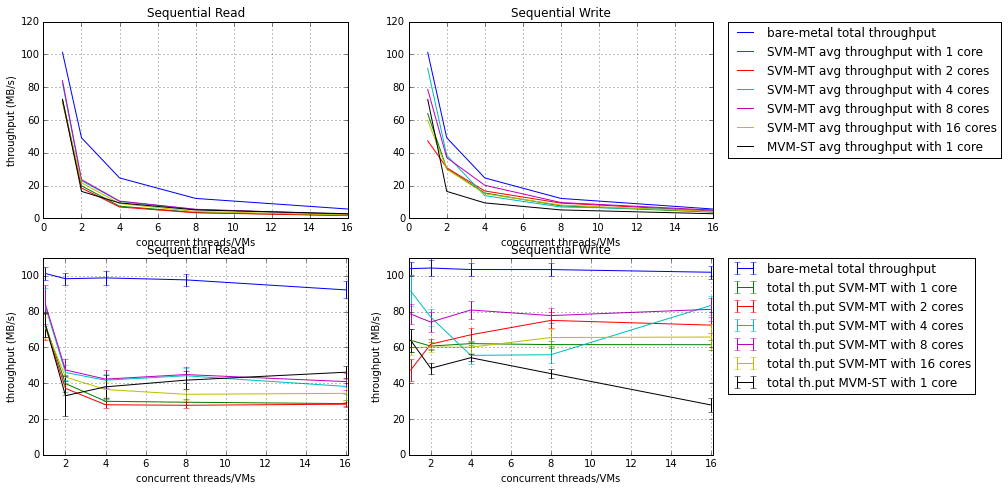

In [6]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 12  # change default size of figures
plt.subplot(321)
plt.plot(x_axis, bwsrbf)
plt.plot(x_axis, bwsrsvm1c) 
plt.plot(x_axis, bwsrsvm2c)
plt.plot(x_axis, bwsrsvm4c)
plt.plot(x_axis, bwsrsvm8c)
plt.plot(x_axis, bwsrsvm16c)
plt.plot(x_axis, bwsrmvm)
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(322)
plt.plot(x_axis, bwsrbf, label = 'bare-metal total throughput')
plt.plot(x_axis, bwswsvm1c, label = 'SVM-MT avg throughput with 1 core') 
plt.plot(x_axis, bwswsvm2c, label = 'SVM-MT avg throughput with 2 cores')
plt.plot(x_axis, bwswsvm4c, label = 'SVM-MT avg throughput with 4 cores')
plt.plot(x_axis, bwswsvm8c, label = 'SVM-MT avg throughput with 8 cores')
plt.plot(x_axis, bwswsvm16c, label = 'SVM-MT avg throughput with 16 cores')
plt.plot(x_axis, bwsrmvm, label = 'MVM-ST avg throughput with 1 core')
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequential Write')
pylab.xlabel('concurrent threads/VMs')
#pylab.ylabel('throughput (MB/s)')

plt.subplot(323)
plt.errorbar(x_axis, aggbwsrbf, ciaggbwsrbf)
plt.errorbar(x_axis, aggbwsrsvm1c, ciaggbwsrsvm1c)
plt.errorbar(x_axis, aggbwsrsvm2c, ciaggbwsrsvm2c)
plt.errorbar(x_axis, aggbwsrsvm4c, ciaggbwsrsvm4c)
plt.errorbar(x_axis, aggbwsrsvm8c, ciaggbwsrsvm8c)
plt.errorbar(x_axis, aggbwsrsvm16c, ciaggbwsrsvm16c)
plt.errorbar(x_axis, aggbwsrmvm, ciaggbwsrmvm)
plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(324)
plt.errorbar(x_axis, aggbwswbf, ciaggbwswbf, label = 'bare-metal total throughput')
plt.errorbar(x_axis, aggbwswsvm1c, ciaggbwswsvm1c, label = 'total th.put SVM-MT with 1 core')
plt.errorbar(x_axis, aggbwswsvm2c, ciaggbwswsvm2c, label = 'total th.put SVM-MT with 2 cores')
plt.errorbar(x_axis, aggbwswsvm4c, ciaggbwswsvm4c, label = 'total th.put SVM-MT with 4 cores')
plt.errorbar(x_axis, aggbwswsvm8c, ciaggbwswsvm8c, label = 'total th.put SVM-MT with 8 cores')
plt.errorbar(x_axis, aggbwswsvm16c, ciaggbwswsvm16c, label = 'total th.put SVM-MT with 16 cores')
plt.errorbar(x_axis, aggbwswmvm, ciaggbwswmvm, label = 'total th.put MVM-ST with 1 core')
plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

#plt.savefig('throughput16procs.pdf')

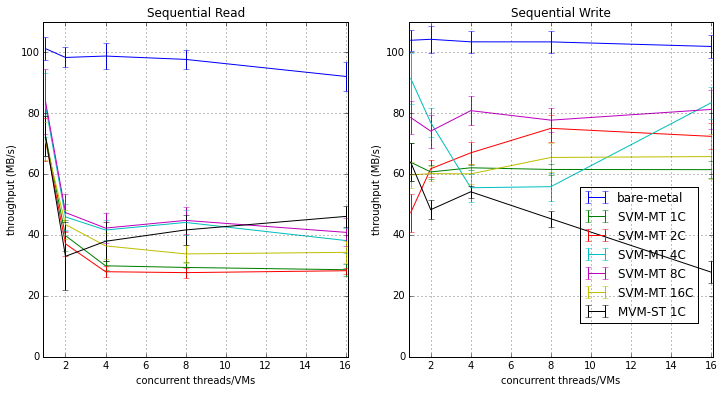

In [7]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 6  # change default size of figures

plt.subplot(121)
plt.errorbar(x_axis, aggbwsrbf, ciaggbwsrbf)
plt.errorbar(x_axis, aggbwsrsvm1c, ciaggbwsrsvm1c)
plt.errorbar(x_axis, aggbwsrsvm2c, ciaggbwsrsvm2c)
plt.errorbar(x_axis, aggbwsrsvm4c, ciaggbwsrsvm4c)
plt.errorbar(x_axis, aggbwsrsvm8c, ciaggbwsrsvm8c)
plt.errorbar(x_axis, aggbwsrsvm16c, ciaggbwsrsvm16c)
plt.errorbar(x_axis, aggbwsrmvm, ciaggbwsrmvm)
plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(122)
plt.errorbar(x_axis, aggbwswbf, ciaggbwswbf, label = 'bare-metal')
plt.errorbar(x_axis, aggbwswsvm1c, ciaggbwswsvm1c, label = 'SVM-MT 1C')
plt.errorbar(x_axis, aggbwswsvm2c, ciaggbwswsvm2c, label = 'SVM-MT 2C')
plt.errorbar(x_axis, aggbwswsvm4c, ciaggbwswsvm4c, label = 'SVM-MT 4C')
plt.errorbar(x_axis, aggbwswsvm8c, ciaggbwswsvm8c, label = 'SVM-MT 8C')
plt.errorbar(x_axis, aggbwswsvm16c, ciaggbwswsvm16c, label = 'SVM-MT 16C')
plt.errorbar(x_axis, aggbwswmvm, ciaggbwswmvm, label = 'MVM-ST 1C')
plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(0.95, 0.1), loc=4, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.savefig('../figures/throughput_cfq.pdf')

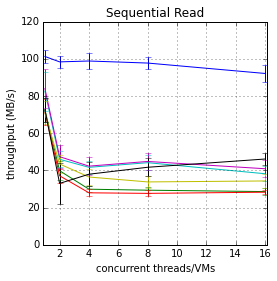

In [8]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 4, 4  # change default size of figures

plt.errorbar(x_axis, aggbwsrbf, ciaggbwsrbf)
plt.errorbar(x_axis, aggbwsrsvm1c, ciaggbwsrsvm1c)
plt.errorbar(x_axis, aggbwsrsvm2c, ciaggbwsrsvm2c)
plt.errorbar(x_axis, aggbwsrsvm4c, ciaggbwsrsvm4c)
plt.errorbar(x_axis, aggbwsrsvm8c, ciaggbwsrsvm8c)
plt.errorbar(x_axis, aggbwsrsvm16c, ciaggbwsrsvm16c)
plt.errorbar(x_axis, aggbwsrmvm, ciaggbwsrmvm)
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')
plt.savefig('throughput_cfq_read.pdf')

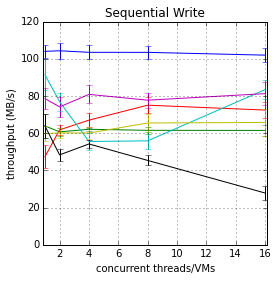

In [9]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 4, 4  # change default size of figures
plt.errorbar(x_axis, aggbwswbf, ciaggbwswbf, label = 'bare-metal')
plt.errorbar(x_axis, aggbwswsvm1c, ciaggbwswsvm1c, label = 'SVM-MT 1C')
plt.errorbar(x_axis, aggbwswsvm2c, ciaggbwswsvm2c, label = 'SVM-MT 2C')
plt.errorbar(x_axis, aggbwswsvm4c, ciaggbwswsvm4c, label = 'SVM-MT 4C')
plt.errorbar(x_axis, aggbwswsvm8c, ciaggbwswsvm8c, label = 'SVM-MT 8C')
plt.errorbar(x_axis, aggbwswsvm16c, ciaggbwswsvm16c, label = 'SVM-MT 16C')
plt.errorbar(x_axis, aggbwswmvm, ciaggbwswmvm, label = 'MVM-ST 1C')
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Write')
#plt.legend(bbox_to_anchor=(0.4, 0.01), loc=4, prop={'size':8}, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.savefig('throughput_cfq_write.pdf')

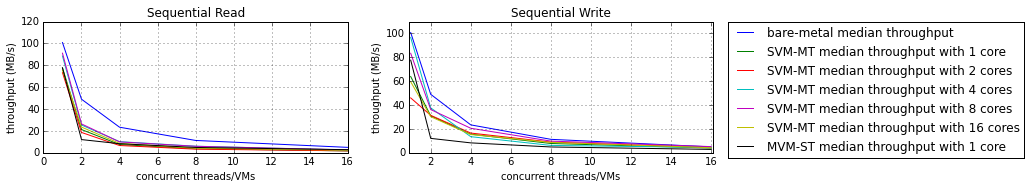

In [10]:
# Plotting using median
# median of 5 tests
mediantpin1test = dtdata.T.median() # Average throughput of each thread/VM in one test
mediantpin5tests = mediantpin1test.groupby(level=0).median() # Average throughput of each thread/VM in 5 tests
mediantpin5tests = mediantpin5tests / 1024 # Converting to Megabytes/second

# Putting median throughput per thread/VM to vector before plotting

medbwsrbf = mediantpin5tests.filter(regex="^SRBF32CTH").tolist()
medbwswbf = mediantpin5tests.filter(regex="^SWBF32CTH").tolist()

medbwsrsvm1c = mediantpin5tests.filter(regex="^SR01VM01CTH").tolist()
medbwswsvm1c = mediantpin5tests.filter(regex="^SW01VM01CTH").tolist()
medbwsrsvm2c = mediantpin5tests.filter(regex="^SR01VM02CTH").tolist()
medbwswsvm2c = mediantpin5tests.filter(regex="^SW01VM02CTH").tolist()
medbwsrsvm4c = mediantpin5tests.filter(regex="^SR01VM04CTH").tolist()
medbwswsvm4c = mediantpin5tests.filter(regex="^SW01VM04CTH").tolist()
medbwsrsvm8c = mediantpin5tests.filter(regex="^SR01VM08CTH").tolist()
medbwswsvm8c = mediantpin5tests.filter(regex="^SW01VM08CTH").tolist()
medbwsrsvm16c = mediantpin5tests.filter(regex="^SR01VM16CTH").tolist()
medbwswsvm16c = mediantpin5tests.filter(regex="^SW01VM16CTH").tolist()

medbwsrmvm = mediantpin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
medbwswmvm = mediantpin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 8  # change default size of figures
plt.subplot(321)
plt.plot(x_axis, medbwsrbf)
plt.plot(x_axis, medbwsrsvm1c) 
plt.plot(x_axis, medbwsrsvm2c)
plt.plot(x_axis, medbwsrsvm4c)
plt.plot(x_axis, medbwsrsvm8c)
plt.plot(x_axis, medbwsrsvm16c)
plt.plot(x_axis, medbwsrmvm)
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(322)
plt.plot(x_axis, medbwsrbf, label = 'bare-metal median throughput')
plt.plot(x_axis, medbwswsvm1c, label = 'SVM-MT median throughput with 1 core') 
plt.plot(x_axis, medbwswsvm2c, label = 'SVM-MT median throughput with 2 cores')
plt.plot(x_axis, medbwswsvm4c, label = 'SVM-MT median throughput with 4 cores')
plt.plot(x_axis, medbwswsvm8c, label = 'SVM-MT median throughput with 8 cores')
plt.plot(x_axis, medbwswsvm16c, label = 'SVM-MT median throughput with 16 cores')
plt.plot(x_axis, medbwsrmvm, label = 'MVM-ST median throughput with 1 core')
plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequential Write')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')


## Bare-metal with diferent number of online cores

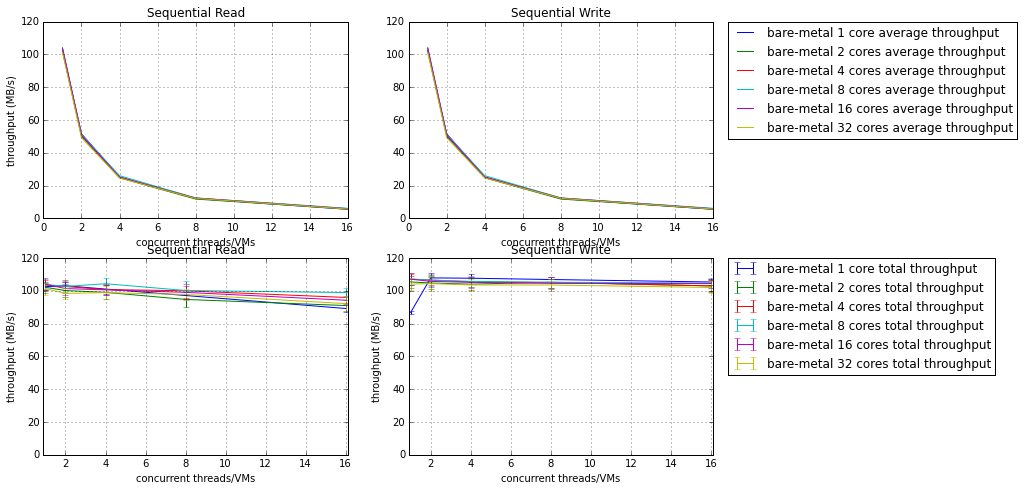

In [11]:
# Plotting figure for baremetal with different number of online core

# Average throughput or througput per thread
bwsrbf1c = avgtpin5tests.filter(regex="^SRBF01CTH").tolist()
bwswbf1c = avgtpin5tests.filter(regex="^SWBF01CTH").tolist()
bwsrbf2c = avgtpin5tests.filter(regex="^SRBF02CTH").tolist()
bwswbf2c = avgtpin5tests.filter(regex="^SWBF02CTH").tolist()
bwsrbf4c = avgtpin5tests.filter(regex="^SRBF04CTH").tolist()
bwswbf4c = avgtpin5tests.filter(regex="^SWBF04CTH").tolist()
bwsrbf8c = avgtpin5tests.filter(regex="^SRBF08CTH").tolist()
bwswbf8c = avgtpin5tests.filter(regex="^SWBF08CTH").tolist()
bwsrbf16c = avgtpin5tests.filter(regex="^SRBF16CTH").tolist()
bwswbf16c = avgtpin5tests.filter(regex="^SWBF16CTH").tolist()
bwsrbf32c = avgtpin5tests.filter(regex="^SRBF32CTH").tolist()
bwswbf32c = avgtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Aggregated throughput or total throughput per test
aggbwsrbf1c = avgaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
aggbwswbf1c = avgaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
aggbwsrbf2c = avgaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
aggbwswbf2c = avgaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
aggbwsrbf4c = avgaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
aggbwswbf4c = avgaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
aggbwsrbf8c = avgaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
aggbwswbf8c = avgaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
aggbwsrbf16c = avgaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
aggbwswbf16c = avgaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
aggbwsrbf32c = avgaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
aggbwswbf32c = avgaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Confidence Interval
ciaggbwsrbf1c = ciaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
ciaggbwswbf1c = ciaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
ciaggbwsrbf2c = ciaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
ciaggbwswbf2c = ciaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
ciaggbwsrbf4c = ciaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
ciaggbwswbf4c = ciaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
ciaggbwsrbf8c = ciaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
ciaggbwswbf8c = ciaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
ciaggbwsrbf16c = ciaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
ciaggbwswbf16c = ciaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
ciaggbwsrbf32c = ciaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggbwswbf32c = ciaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 12  # change default size of figures
plt.subplot(321)
plt.plot(x_axis, bwsrbf1c)
plt.plot(x_axis, bwsrbf2c)
plt.plot(x_axis, bwsrbf4c)
plt.plot(x_axis, bwsrbf8c)
plt.plot(x_axis, bwsrbf16c)
plt.plot(x_axis, bwsrbf32c)
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(322)
plt.plot(x_axis, bwsrbf1c, label = 'bare-metal 1 core average throughput')
plt.plot(x_axis, bwsrbf2c, label = 'bare-metal 2 cores average throughput')
plt.plot(x_axis, bwsrbf4c, label = 'bare-metal 4 cores average throughput')
plt.plot(x_axis, bwsrbf8c, label = 'bare-metal 8 cores average throughput')
plt.plot(x_axis, bwsrbf16c, label = 'bare-metal 16 cores average throughput')
plt.plot(x_axis, bwsrbf32c, label = 'bare-metal 32 cores average throughput')
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequential Write')
pylab.xlabel('concurrent threads/VMs')
#pylab.ylabel('throughput (MB/s)')

plt.subplot(323)
plt.errorbar(x_axis, aggbwsrbf1c, ciaggbwsrbf1c)
plt.errorbar(x_axis, aggbwsrbf2c, ciaggbwsrbf2c)
plt.errorbar(x_axis, aggbwsrbf4c, ciaggbwsrbf4c)
plt.errorbar(x_axis, aggbwsrbf8c, ciaggbwsrbf8c)
plt.errorbar(x_axis, aggbwsrbf16c, ciaggbwsrbf16c)
plt.errorbar(x_axis, aggbwsrbf32c, ciaggbwsrbf32c)
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(324)
plt.errorbar(x_axis, aggbwswbf1c, ciaggbwswbf1c, label = 'bare-metal 1 core total throughput')
plt.errorbar(x_axis, aggbwswbf2c, ciaggbwswbf2c, label = 'bare-metal 2 cores total throughput')
plt.errorbar(x_axis, aggbwswbf4c, ciaggbwswbf4c, label = 'bare-metal 4 cores total throughput')
plt.errorbar(x_axis, aggbwswbf8c, ciaggbwswbf8c, label = 'bare-metal 8 cores total throughput')
plt.errorbar(x_axis, aggbwswbf16c, ciaggbwswbf16c, label = 'bare-metal 16 cores total throughput')
plt.errorbar(x_axis, aggbwswbf32c, ciaggbwswbf32c, label = 'bare-metal 32 cores total throughput')
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')


To see the effect of the number of CPU core on disk IO, we try reducing the number of online cores on the baremetal system to see whether we get the same discrepancy like the case of VM with different number of cores.

## Bare-metal with cfq scheduler

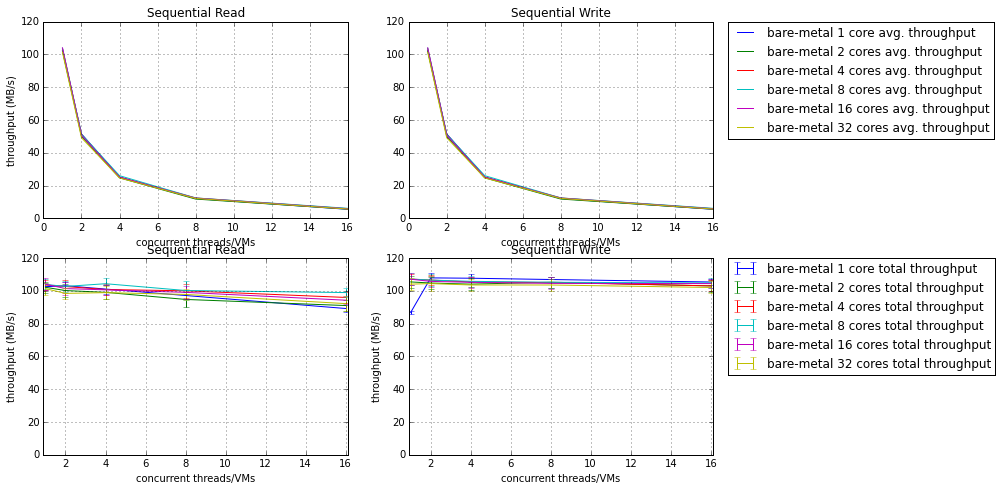

In [12]:
# Plotting figure for baremetal with different number of online core and iodepth of 256
bmresult = pd.read_csv('data/bw16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
bmdata = bmresult[range(1,17)]
bmindex = bmresult[0]
bmdata.index = bmindex.str.replace('T[0-2][0-9]', '',case=False)

# To calculate the average throughput, we first calculate average throughput each thread has in one test, then again take the
# average of 5 tests
bmavgtpin1test = bmdata.T.mean() # Average throughput of each thread/VM in one test
bmavgtpin5tests = bmavgtpin1test.groupby(level=0).mean() # Average throughput of each thread/VM in 5 tests
bmavgtpin5tests = bmavgtpin5tests / 1024 # Converting to Megabytes/second

# Average throughput or througput per thread
bwsrbf1c = bmavgtpin5tests.filter(regex="^SRBF01CTH").tolist()
bwswbf1c = bmavgtpin5tests.filter(regex="^SWBF01CTH").tolist()
bwsrbf2c = bmavgtpin5tests.filter(regex="^SRBF02CTH").tolist()
bwswbf2c = bmavgtpin5tests.filter(regex="^SWBF02CTH").tolist()
bwsrbf4c = bmavgtpin5tests.filter(regex="^SRBF04CTH").tolist()
bwswbf4c = bmavgtpin5tests.filter(regex="^SWBF04CTH").tolist()
bwsrbf8c = bmavgtpin5tests.filter(regex="^SRBF08CTH").tolist()
bwswbf8c = bmavgtpin5tests.filter(regex="^SWBF08CTH").tolist()
bwsrbf16c = bmavgtpin5tests.filter(regex="^SRBF16CTH").tolist()
bwswbf16c = bmavgtpin5tests.filter(regex="^SWBF16CTH").tolist()
bwsrbf32c = bmavgtpin5tests.filter(regex="^SRBF32CTH").tolist()
bwswbf32c = bmavgtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Calculate aggregated throughput on each host of each test, then taking the average
bmaggtpin1test = bmdata.T.sum() # Aggregate throughput on each host in one test
bmavgaggtpintestgrouped = bmaggtpin1test.groupby(level=0)
bmavgaggtpin5tests = bmavgaggtpintestgrouped.mean() # Then calculate the average of the total throughput through 5 tests
bmavgaggtpin5tests = bmavgaggtpin5tests / 1024 # Convert to MB/s
bmciaggtpin5tests = bmavgaggtpintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%
bmciaggtpin5tests = bmciaggtpin5tests / 1024 # Convert to same scale with mean

# Aggregated throughput or total throughput per test
aggbwsrbf1c = bmavgaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
aggbwswbf1c = bmavgaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
aggbwsrbf2c = bmavgaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
aggbwswbf2c = bmavgaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
aggbwsrbf4c = bmavgaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
aggbwswbf4c = bmavgaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
aggbwsrbf8c = bmavgaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
aggbwswbf8c = bmavgaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
aggbwsrbf16c = bmavgaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
aggbwswbf16c = bmavgaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
aggbwsrbf32c = bmavgaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
aggbwswbf32c = bmavgaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Confidence Interval
ciaggbwsrbf1c = bmciaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
ciaggbwswbf1c = bmciaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
ciaggbwsrbf2c = bmciaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
ciaggbwswbf2c = bmciaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
ciaggbwsrbf4c = bmciaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
ciaggbwswbf4c = bmciaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
ciaggbwsrbf8c = bmciaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
ciaggbwswbf8c = bmciaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
ciaggbwsrbf16c = bmciaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
ciaggbwswbf16c = bmciaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
ciaggbwsrbf32c = bmciaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggbwswbf32c = bmciaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 12  # change default size of figures
plt.subplot(321)
plt.plot(x_axis, bwsrbf1c)
plt.plot(x_axis, bwsrbf2c)
plt.plot(x_axis, bwsrbf4c)
plt.plot(x_axis, bwsrbf8c)
plt.plot(x_axis, bwsrbf16c)
plt.plot(x_axis, bwsrbf32c)
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(322)
plt.plot(x_axis, bwsrbf1c, label = 'bare-metal 1 core avg. throughput')
plt.plot(x_axis, bwsrbf2c, label = 'bare-metal 2 cores avg. throughput')
plt.plot(x_axis, bwsrbf4c, label = 'bare-metal 4 cores avg. throughput')
plt.plot(x_axis, bwsrbf8c, label = 'bare-metal 8 cores avg. throughput')
plt.plot(x_axis, bwsrbf16c, label = 'bare-metal 16 cores avg. throughput')
plt.plot(x_axis, bwsrbf32c, label = 'bare-metal 32 cores avg. throughput')
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequential Write')
pylab.xlabel('concurrent threads/VMs')
#pylab.ylabel('throughput (MB/s)')

plt.subplot(323)
plt.errorbar(x_axis, aggbwsrbf1c, ciaggbwsrbf1c)
plt.errorbar(x_axis, aggbwsrbf2c, ciaggbwsrbf2c)
plt.errorbar(x_axis, aggbwsrbf4c, ciaggbwsrbf4c)
plt.errorbar(x_axis, aggbwsrbf8c, ciaggbwsrbf8c)
plt.errorbar(x_axis, aggbwsrbf16c, ciaggbwsrbf16c)
plt.errorbar(x_axis, aggbwsrbf32c, ciaggbwsrbf32c)
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(324)
plt.errorbar(x_axis, aggbwswbf1c, ciaggbwswbf1c, label = 'bare-metal 1 core total throughput')
plt.errorbar(x_axis, aggbwswbf2c, ciaggbwswbf2c, label = 'bare-metal 2 cores total throughput')
plt.errorbar(x_axis, aggbwswbf4c, ciaggbwswbf4c, label = 'bare-metal 4 cores total throughput')
plt.errorbar(x_axis, aggbwswbf8c, ciaggbwswbf8c, label = 'bare-metal 8 cores total throughput')
plt.errorbar(x_axis, aggbwswbf16c, ciaggbwswbf16c, label = 'bare-metal 16 cores total throughput')
plt.errorbar(x_axis, aggbwswbf32c, ciaggbwswbf32c, label = 'bare-metal 32 cores total throughput')
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

By chance I found out that the scheduler that we use for disk IO is deadline scheduler, not the default CFQ that we are using in the VM. The result here repeat the result that we have in the early version of the test. This leads to an unavoidable task is to rerun the measurement for virtualization (and to try other combination of VM scheduler and host scheduler)

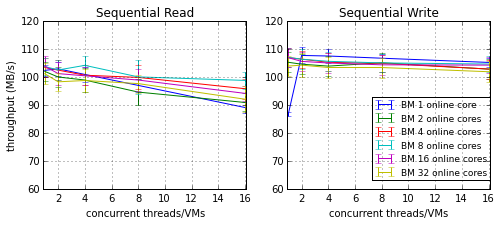

In [13]:
# Plotting figure for baremetal with different number of online core and iodepth of 256
bmresult = pd.read_csv('data/bw16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
bmdata = bmresult[range(1,17)]
bmindex = bmresult[0]
bmdata.index = bmindex.str.replace('T[0-2][0-9]', '',case=False)

# To calculate the average throughput, we first calculate average throughput each thread has in one test, then again take the
# average of 5 tests
bmavgtpin1test = bmdata.T.mean() # Average throughput of each thread/VM in one test
bmavgtpin5tests = bmavgtpin1test.groupby(level=0).mean() # Average throughput of each thread/VM in 5 tests
bmavgtpin5tests = bmavgtpin5tests / 1024 # Converting to Megabytes/second

# Average throughput or througput per thread
bwsrbf1c = bmavgtpin5tests.filter(regex="^SRBF01CTH").tolist()
bwswbf1c = bmavgtpin5tests.filter(regex="^SWBF01CTH").tolist()
bwsrbf2c = bmavgtpin5tests.filter(regex="^SRBF02CTH").tolist()
bwswbf2c = bmavgtpin5tests.filter(regex="^SWBF02CTH").tolist()
bwsrbf4c = bmavgtpin5tests.filter(regex="^SRBF04CTH").tolist()
bwswbf4c = bmavgtpin5tests.filter(regex="^SWBF04CTH").tolist()
bwsrbf8c = bmavgtpin5tests.filter(regex="^SRBF08CTH").tolist()
bwswbf8c = bmavgtpin5tests.filter(regex="^SWBF08CTH").tolist()
bwsrbf16c = bmavgtpin5tests.filter(regex="^SRBF16CTH").tolist()
bwswbf16c = bmavgtpin5tests.filter(regex="^SWBF16CTH").tolist()
bwsrbf32c = bmavgtpin5tests.filter(regex="^SRBF32CTH").tolist()
bwswbf32c = bmavgtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Calculate aggregated throughput on each host of each test, then taking the average
bmaggtpin1test = bmdata.T.sum() # Aggregate throughput on each host in one test
bmavgaggtpintestgrouped = bmaggtpin1test.groupby(level=0)
bmavgaggtpin5tests = bmavgaggtpintestgrouped.mean() # Then calculate the average of the total throughput through 5 tests
bmavgaggtpin5tests = bmavgaggtpin5tests / 1024 # Convert to MB/s
bmciaggtpin5tests = bmavgaggtpintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%
bmciaggtpin5tests = bmciaggtpin5tests / 1024 # Convert to same scale with mean

# Aggregated throughput or total throughput per test
aggbwsrbf1c = bmavgaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
aggbwswbf1c = bmavgaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
aggbwsrbf2c = bmavgaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
aggbwswbf2c = bmavgaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
aggbwsrbf4c = bmavgaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
aggbwswbf4c = bmavgaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
aggbwsrbf8c = bmavgaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
aggbwswbf8c = bmavgaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
aggbwsrbf16c = bmavgaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
aggbwswbf16c = bmavgaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
aggbwsrbf32c = bmavgaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
aggbwswbf32c = bmavgaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Confidence Interval
ciaggbwsrbf1c = bmciaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
ciaggbwswbf1c = bmciaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
ciaggbwsrbf2c = bmciaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
ciaggbwswbf2c = bmciaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
ciaggbwsrbf4c = bmciaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
ciaggbwswbf4c = bmciaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
ciaggbwsrbf8c = bmciaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
ciaggbwswbf8c = bmciaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
ciaggbwsrbf16c = bmciaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
ciaggbwswbf16c = bmciaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
ciaggbwsrbf32c = bmciaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggbwswbf32c = bmciaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 8, 3  # change default size of figures

plt.subplot(121)
plt.errorbar(x_axis, aggbwsrbf1c, ciaggbwsrbf1c)
plt.errorbar(x_axis, aggbwsrbf2c, ciaggbwsrbf2c)
plt.errorbar(x_axis, aggbwsrbf4c, ciaggbwsrbf4c)
plt.errorbar(x_axis, aggbwsrbf8c, ciaggbwsrbf8c)
plt.errorbar(x_axis, aggbwsrbf16c, ciaggbwsrbf16c)
plt.errorbar(x_axis, aggbwsrbf32c, ciaggbwsrbf32c)
plt.axis([0.9, 16.1, 60, 120])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(122)
plt.errorbar(x_axis, aggbwswbf1c, ciaggbwswbf1c, label = 'BM 1 online core')
plt.errorbar(x_axis, aggbwswbf2c, ciaggbwswbf2c, label = 'BM 2 online cores')
plt.errorbar(x_axis, aggbwswbf4c, ciaggbwswbf4c, label = 'BM 4 online cores')
plt.errorbar(x_axis, aggbwswbf8c, ciaggbwswbf8c, label = 'BM 8 online cores')
plt.errorbar(x_axis, aggbwswbf16c, ciaggbwswbf16c, label = 'BM 16 online cores')
plt.errorbar(x_axis, aggbwswbf32c, ciaggbwswbf32c, label = 'BM 32 online cores')
plt.axis([0.9, 16.1, 60, 120])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1, 0.05), loc=4, prop={'size':9}, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
#pylab.ylabel('throughput (MB/s)')
plt.savefig('throughput_cfq_bmdiffonlinecore.pdf')

## Bare-metal with noop scheduler 

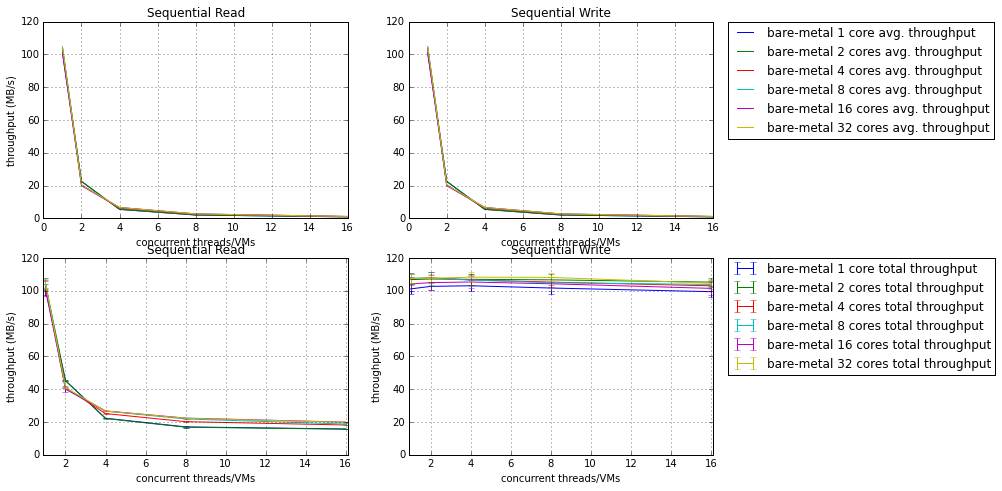

In [14]:
# Plotting figure for baremetal with different number of online core and iodepth of 256
bmresult = pd.read_csv('data/bw16p4gbf12cache_noop.csv', delimiter=' ', header=None)
bmdata = bmresult[range(1,17)]
bmindex = bmresult[0]
bmdata.index = bmindex.str.replace('T[0-2][0-9]', '',case=False)

# To calculate the average throughput, we first calculate average throughput each thread has in one test, then again take the
# average of 5 tests
bmavgtpin1test = bmdata.T.mean() # Average throughput of each thread/VM in one test
bmavgtpin5tests = bmavgtpin1test.groupby(level=0).mean() # Average throughput of each thread/VM in 5 tests
bmavgtpin5tests = bmavgtpin5tests / 1024 # Converting to Megabytes/second

# Average throughput or througput per thread
bwsrbf1c = bmavgtpin5tests.filter(regex="^SRBF01CTH").tolist()
bwswbf1c = bmavgtpin5tests.filter(regex="^SWBF01CTH").tolist()
bwsrbf2c = bmavgtpin5tests.filter(regex="^SRBF02CTH").tolist()
bwswbf2c = bmavgtpin5tests.filter(regex="^SWBF02CTH").tolist()
bwsrbf4c = bmavgtpin5tests.filter(regex="^SRBF04CTH").tolist()
bwswbf4c = bmavgtpin5tests.filter(regex="^SWBF04CTH").tolist()
bwsrbf8c = bmavgtpin5tests.filter(regex="^SRBF08CTH").tolist()
bwswbf8c = bmavgtpin5tests.filter(regex="^SWBF08CTH").tolist()
bwsrbf16c = bmavgtpin5tests.filter(regex="^SRBF16CTH").tolist()
bwswbf16c = bmavgtpin5tests.filter(regex="^SWBF16CTH").tolist()
bwsrbf32c = bmavgtpin5tests.filter(regex="^SRBF32CTH").tolist()
bwswbf32c = bmavgtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Calculate aggregated throughput on each host of each test, then taking the average
bmaggtpin1test = bmdata.T.sum() # Aggregate throughput on each host in one test
bmavgaggtpintestgrouped = bmaggtpin1test.groupby(level=0)
bmavgaggtpin5tests = bmavgaggtpintestgrouped.mean() # Then calculate the average of the total throughput through 5 tests
bmavgaggtpin5tests = bmavgaggtpin5tests / 1024 # Convert to MB/s
bmciaggtpin5tests = bmavgaggtpintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%
bmciaggtpin5tests = bmciaggtpin5tests / 1024 # Convert to same scale with mean

# Aggregated throughput or total throughput per test
aggbwsrbf1c = bmavgaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
aggbwswbf1c = bmavgaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
aggbwsrbf2c = bmavgaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
aggbwswbf2c = bmavgaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
aggbwsrbf4c = bmavgaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
aggbwswbf4c = bmavgaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
aggbwsrbf8c = bmavgaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
aggbwswbf8c = bmavgaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
aggbwsrbf16c = bmavgaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
aggbwswbf16c = bmavgaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
aggbwsrbf32c = bmavgaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
aggbwswbf32c = bmavgaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

# Confidence Interval
ciaggbwsrbf1c = bmciaggtpin5tests.filter(regex="^SRBF01CTH").tolist()
ciaggbwswbf1c = bmciaggtpin5tests.filter(regex="^SWBF01CTH").tolist()
ciaggbwsrbf2c = bmciaggtpin5tests.filter(regex="^SRBF02CTH").tolist()
ciaggbwswbf2c = bmciaggtpin5tests.filter(regex="^SWBF02CTH").tolist()
ciaggbwsrbf4c = bmciaggtpin5tests.filter(regex="^SRBF04CTH").tolist()
ciaggbwswbf4c = bmciaggtpin5tests.filter(regex="^SWBF04CTH").tolist()
ciaggbwsrbf8c = bmciaggtpin5tests.filter(regex="^SRBF08CTH").tolist()
ciaggbwswbf8c = bmciaggtpin5tests.filter(regex="^SWBF08CTH").tolist()
ciaggbwsrbf16c = bmciaggtpin5tests.filter(regex="^SRBF16CTH").tolist()
ciaggbwswbf16c = bmciaggtpin5tests.filter(regex="^SWBF16CTH").tolist()
ciaggbwsrbf32c = bmciaggtpin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggbwswbf32c = bmciaggtpin5tests.filter(regex="^SWBF32CTH").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 12  # change default size of figures
plt.subplot(321)
plt.plot(x_axis, bwsrbf1c)
plt.plot(x_axis, bwsrbf2c)
plt.plot(x_axis, bwsrbf4c)
plt.plot(x_axis, bwsrbf8c)
plt.plot(x_axis, bwsrbf16c)
plt.plot(x_axis, bwsrbf32c)
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(322)
plt.plot(x_axis, bwsrbf1c, label = 'bare-metal 1 core avg. throughput')
plt.plot(x_axis, bwsrbf2c, label = 'bare-metal 2 cores avg. throughput')
plt.plot(x_axis, bwsrbf4c, label = 'bare-metal 4 cores avg. throughput')
plt.plot(x_axis, bwsrbf8c, label = 'bare-metal 8 cores avg. throughput')
plt.plot(x_axis, bwsrbf16c, label = 'bare-metal 16 cores avg. throughput')
plt.plot(x_axis, bwsrbf32c, label = 'bare-metal 32 cores avg. throughput')
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequential Write')
pylab.xlabel('concurrent threads/VMs')
#pylab.ylabel('throughput (MB/s)')

plt.subplot(323)
plt.errorbar(x_axis, aggbwsrbf1c, ciaggbwsrbf1c)
plt.errorbar(x_axis, aggbwsrbf2c, ciaggbwsrbf2c)
plt.errorbar(x_axis, aggbwsrbf4c, ciaggbwsrbf4c)
plt.errorbar(x_axis, aggbwsrbf8c, ciaggbwsrbf8c)
plt.errorbar(x_axis, aggbwsrbf16c, ciaggbwsrbf16c)
plt.errorbar(x_axis, aggbwsrbf32c, ciaggbwsrbf32c)
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

plt.subplot(324)
plt.errorbar(x_axis, aggbwswbf1c, ciaggbwswbf1c, label = 'bare-metal 1 core total throughput')
plt.errorbar(x_axis, aggbwswbf2c, ciaggbwswbf2c, label = 'bare-metal 2 cores total throughput')
plt.errorbar(x_axis, aggbwswbf4c, ciaggbwswbf4c, label = 'bare-metal 4 cores total throughput')
plt.errorbar(x_axis, aggbwswbf8c, ciaggbwswbf8c, label = 'bare-metal 8 cores total throughput')
plt.errorbar(x_axis, aggbwswbf16c, ciaggbwswbf16c, label = 'bare-metal 16 cores total throughput')
plt.errorbar(x_axis, aggbwswbf32c, ciaggbwswbf32c, label = 'bare-metal 32 cores total throughput')
plt.axis([0.9, 16.1, 0, 120])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('throughput (MB/s)')

## Throughput normalization

_(throughput of bare-metal is used as baseline)_

In [15]:
from __future__ import division # floating point division in Py2x
# for throughput per thread/VM
nml_bwsrbf = [x/y for x,y in zip(bwsrbf,bwsrbf)]
nml_bwswbf = [x/y for x,y in zip(bwswbf,bwswbf)]

nml_bwsrsvm1c = [x/y for x,y in zip(bwsrsvm1c,bwsrbf)]
nml_bwswsvm1c = [x/y for x,y in zip(bwswsvm1c,bwswbf)]
nml_bwsrsvm2c = [x/y for x,y in zip(bwsrsvm2c,bwsrbf)]
nml_bwswsvm2c = [x/y for x,y in zip(bwswsvm2c,bwswbf)]
nml_bwsrsvm4c = [x/y for x,y in zip(bwsrsvm4c,bwsrbf)]
nml_bwswsvm4c = [x/y for x,y in zip(bwswsvm4c,bwswbf)]
nml_bwsrsvm8c = [x/y for x,y in zip(bwsrsvm8c,bwsrbf)]
nml_bwswsvm8c = [x/y for x,y in zip(bwswsvm8c,bwswbf)]
nml_bwsrsvm16c = [x/y for x,y in zip(bwsrsvm16c,bwsrbf)]
nml_bwswsvm16c = [x/y for x,y in zip(bwswsvm16c,bwswbf)]

nml_bwsrmvm = [x/y for x,y in zip(bwsrmvm,bwsrbf)]
nml_bwswmvm = [x/y for x,y in zip(bwswmvm,bwswbf)]

# for aggregated throughput
nml_aggbwsrbf = [x/y for x,y in zip(aggbwsrbf,aggbwsrbf)]
nml_aggbwswbf = [x/y for x,y in zip(aggbwswbf,aggbwswbf)]

nml_aggbwsrsvm1c = [x/y for x,y in zip(aggbwsrsvm1c,aggbwsrbf)]
nml_aggbwswsvm1c = [x/y for x,y in zip(aggbwswsvm1c,aggbwswbf)]
nml_aggbwsrsvm2c = [x/y for x,y in zip(aggbwsrsvm2c,aggbwsrbf)]
nml_aggbwswsvm2c = [x/y for x,y in zip(aggbwswsvm2c,aggbwswbf)]
nml_aggbwsrsvm4c = [x/y for x,y in zip(aggbwsrsvm4c,aggbwsrbf)]
nml_aggbwswsvm4c = [x/y for x,y in zip(aggbwswsvm4c,aggbwswbf)]
nml_aggbwsrsvm8c = [x/y for x,y in zip(aggbwsrsvm8c,aggbwsrbf)]
nml_aggbwswsvm8c = [x/y for x,y in zip(aggbwswsvm8c,aggbwswbf)]
nml_aggbwsrsvm16c = [x/y for x,y in zip(aggbwsrsvm16c,aggbwsrbf)]
nml_aggbwswsvm16c = [x/y for x,y in zip(aggbwswsvm16c,aggbwswbf)]

nml_aggbwsrmvm = [x/y for x,y in zip(aggbwsrmvm,aggbwsrbf)]
nml_aggbwswmvm = [x/y for x,y in zip(aggbwswmvm,aggbwswbf)]

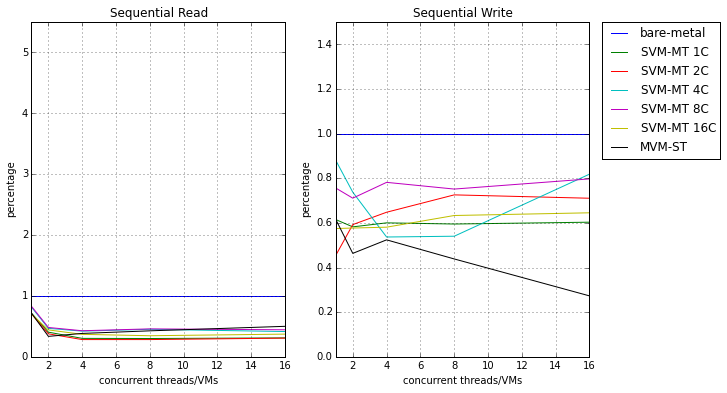

In [16]:
pylab.rcParams['figure.figsize'] = 10, 6  # change default size of figures
x_axis = [1,2,4,8,16]

plt.subplot(121)
plt.plot(x_axis, nml_aggbwsrbf, label = 'bare-metal')
plt.plot(x_axis, nml_aggbwsrsvm1c, label = 'SVM-MT 1C')
plt.plot(x_axis, nml_aggbwsrsvm2c, label = 'SVM-MT 2C')
plt.plot(x_axis, nml_aggbwsrsvm4c, label = 'SVM-MT 4C')
plt.plot(x_axis, nml_aggbwsrsvm8c, label = 'SVM-MT 8C')
plt.plot(x_axis, nml_aggbwsrsvm16c, label = 'SVM-MT 16C')
plt.plot(x_axis, nml_aggbwsrmvm, label = 'MVM-ST')
plt.axis([1, 16, 0, 5.5])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('percentage')

plt.subplot(122)
plt.plot(x_axis, nml_aggbwswbf, label = 'bare-metal')
plt.plot(x_axis, nml_aggbwswsvm1c, label = 'SVM-MT 1C')
plt.plot(x_axis, nml_aggbwswsvm2c, label = 'SVM-MT 2C')
plt.plot(x_axis, nml_aggbwswsvm4c, label = 'SVM-MT 4C')
plt.plot(x_axis, nml_aggbwswsvm8c, label = 'SVM-MT 8C')
plt.plot(x_axis, nml_aggbwswsvm16c, label = 'SVM-MT 16C')
plt.plot(x_axis, nml_aggbwswmvm, label = 'MVM-ST')
plt.axis([1, 16, 0, 1.5])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('percentage')

#plt.savefig('nml_throughput16procs.pdf')

In order to see the overhead in compare to the baremetal, we will look at the normalization of the aggregated throughput of the three platforms: bare-metal, single VM with multiple threads, and multiple VMs with single thread. We set the throughput of baremetal as the base and compare with the VM ones.

To answer these questions, we will look into other metrics of the experiments: Jain Fairness Index, CPU utilisation, Disk Utilization, Context Switching.

## Jain Fairness Index

In [17]:
jfi = dtdata.T.sum()**2/dtdata.T.count()/(dtdata**2).T.sum() #Calculate Jair Fairness Index for each test
jfigrouped = jfi.groupby(level=0)
jfiavg = jfigrouped.mean() # Calculate JFI average from 5 tests

# for plotting confident interval
# jfistd = jfigrouped.std() # Standard Deviation
cijfi = jfigrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%

# prepare for plotting
jfisrbf = jfiavg.filter(regex="^SRBF32CTH").tolist()
jfiswbf = jfiavg.filter(regex="^SWBF32CTH").tolist()

jfisrsvm1c = jfiavg.filter(regex="^SR01VM01CTH").tolist()
jfiswsvm1c = jfiavg.filter(regex="^SW01VM01CTH").tolist()
jfisrsvm2c = jfiavg.filter(regex="^SR01VM02CTH").tolist()
jfiswsvm2c = jfiavg.filter(regex="^SW01VM02CTH").tolist()
jfisrsvm4c = jfiavg.filter(regex="^SR01VM04CTH").tolist()
jfiswsvm4c = jfiavg.filter(regex="^SW01VM04CTH").tolist()
jfisrsvm8c = jfiavg.filter(regex="^SR01VM08CTH").tolist()
jfiswsvm8c = jfiavg.filter(regex="^SW01VM08CTH").tolist()
jfisrsvm16c = jfiavg.filter(regex="^SR01VM16CTH").tolist()
jfiswsvm16c = jfiavg.filter(regex="^SW01VM16CTH").tolist()

jfisrmvm = jfiavg.filter(regex="^SR[0-9]+VM01CTH01").tolist()
jfiswmvm = jfiavg.filter(regex="^SW[0-9]+VM01CTH01").tolist()


cijfisrbf = cijfi.filter(regex="^SRBF32CTH").tolist()
cijfiswbf = cijfi.filter(regex="^SWBF32CTH").tolist()

cijfisrsvm1c = cijfi.filter(regex="^SR01VM01CTH").tolist()
cijfiswsvm1c = cijfi.filter(regex="^SW01VM01CTH").tolist()
cijfisrsvm2c = cijfi.filter(regex="^SR01VM02CTH").tolist()
cijfiswsvm2c = cijfi.filter(regex="^SW01VM02CTH").tolist()
cijfisrsvm4c = cijfi.filter(regex="^SR01VM04CTH").tolist()
cijfiswsvm4c = cijfi.filter(regex="^SW01VM04CTH").tolist()
cijfisrsvm8c = cijfi.filter(regex="^SR01VM08CTH").tolist()
cijfiswsvm8c = cijfi.filter(regex="^SW01VM08CTH").tolist()
cijfisrsvm16c = cijfi.filter(regex="^SR01VM16CTH").tolist()
cijfiswsvm16c = cijfi.filter(regex="^SW01VM16CTH").tolist()

cijfisrmvm = cijfi.filter(regex="^SR[0-9]+VM01CTH01").tolist()
cijfiswmvm = cijfi.filter(regex="^SW[0-9]+VM01CTH01").tolist()

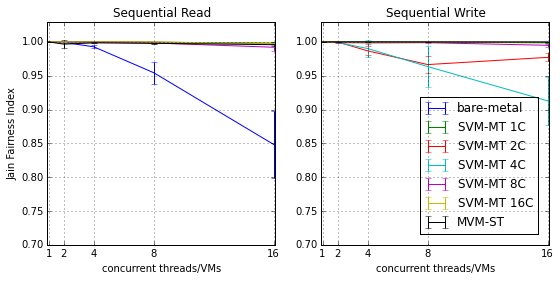

In [18]:
pylab.rcParams['figure.figsize'] = 9, 4  # change default size of figures
x_axis = [1,2,4,8,16]

plt.subplot(121)
plt.errorbar(x_axis, jfisrbf, cijfisrbf, label = 'bare-metal')
plt.errorbar(x_axis, jfisrsvm1c, cijfisrsvm1c, label = 'SVM-MT 1C')
plt.errorbar(x_axis, jfisrsvm2c, cijfisrsvm2c, label = 'SVM-MT 2C')
plt.errorbar(x_axis, jfisrsvm4c, cijfisrsvm4c, label = 'SVM-MT 4C')
plt.errorbar(x_axis, jfisrsvm8c, cijfisrsvm8c, label = 'SVM-MT 8C')
plt.errorbar(x_axis, jfisrsvm16c, cijfisrsvm16c, label = 'SVM-MT 16C')
plt.errorbar(x_axis, jfisrmvm, cijfisrmvm, label = 'MVM-ST')
plt.axis([0.9, 16.1, 0.7, 1.03])
plt.grid(True)
plt.title('Sequential Read')
plt.xlabel('concurrent threads/VMs')
plt.ylabel('Jain Fairness Index')
plt.xticks(x_axis)

plt.subplot(122)
plt.errorbar(x_axis, jfiswbf, cijfiswbf, label = 'bare-metal')
plt.errorbar(x_axis, jfiswsvm1c, cijfiswsvm1c, label = 'SVM-MT 1C')
plt.errorbar(x_axis, jfiswsvm2c, cijfiswsvm2c, label = 'SVM-MT 2C')
plt.errorbar(x_axis, jfiswsvm4c, cijfiswsvm4c, label = 'SVM-MT 4C')
plt.errorbar(x_axis, jfiswsvm8c, cijfiswsvm8c, label = 'SVM-MT 8C')
plt.errorbar(x_axis, jfiswsvm16c, cijfiswsvm16c, label = 'SVM-MT 16C')
plt.errorbar(x_axis, jfiswmvm, cijfiswmvm, label = 'MVM-ST')
plt.axis([0.9, 16.1, 0.7, 1.03])
plt.grid(True)
plt.title('Sequential Write')
plt.xlabel('concurrent threads/VMs')
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)
#plt.ylabel('JFI index')
plt.xticks(x_axis)

plt.savefig('JFI.pdf')

Jain Fairness Index (JFI) has a range from 0 to 1 which indicates the level of fairness between concurrent threads. If the threads receive equal partition of bandwidth, we would achieve index of 1. If only k of n flows receive equal bandwidth (and others get none), index is k/n. In the worst case, JFI has the index of 0. We plot some figures of JFI for the three platforms with confident interval of 95%. The figures show that JFI is always 1 which means that threads have very perfectly equal throughput or fair to each others.
CFQ scheduler use 64 queues when dealing synchronous request and only one queue when dealing with asynchronous request. The behaviors of baremetal can be because of this.

## CPU Utilization

For CPU utilization, FIO relies on _getrusage()_. _Getrusage()_ returns resource usage statistics for the calling thread.
The resource usages are returned in the structure pointed by the usage caller, which has the following form:
~~~
struct rusage {
    struct timeval ru_utime; /* user CPU time used */
    struct timeval ru_stime; /* system CPU time used */
    ...
    long   ru_minflt;        /* page reclaims (soft page faults) */
    long   ru_majflt;        /* page faults (hard page faults) */
    long   ru_nswap;         /* swaps */
    ...
    long   ru_nvcsw;         /* voluntary context switches */
    long   ru_nivcsw;        /* involuntary context switches */
};
~~~
and contains inside the _struct_:
* _ru_utime_: This is the total amount of time spent executing in user mode, expressed in a _timeval_ structure (seconds plus microseconds).
* _ru_stime_: This is the total amount of time spent executing in kernel mode, expressed in a _timeval_ structure (seconds plus microseconds).
* _ru_nvcsw_: The number of times a context switch resulted due to a process voluntarily giving up the processor before its time slice was completed (usually to await availability of a resource).
* _ru_nivcsw_: The number of times a context switch resulted due to a higher priority process becoming runnable or because the current process exceeded its time slice.

FIO reports the CPU utilization for each thread by (_user_time/total_run_time_) and (_system_time/total_run_time_), where:
* _user_time_ is the duration that the thread spending in user space
* _system_time_ is the duration the that the thread spending in kernel space
* _total_run_time_ is the duration from the time that thread starts until the time that thread finishs or the wall lock time.

~~~
	runtime = ts->total_run_time;
	if (runtime) {
		double runt = (double) runtime;

		usr_cpu = (double) ts->usr_time * 100 / runt;
		sys_cpu = (double) ts->sys_time * 100 / runt;
	} else {
		usr_cpu = 0;
		sys_cpu = 0;
	}
~~~
In this report, we especially focus on the the serving time (the time that thread actually uses the CPU) and the waiting time (the time that thread has to wait for the others until its slice is up). Serving time and Waiting time were calculated by this formular:
~~~
    serving_time = user_time + kernel_time
    waiting_time = total_thread_runtime - serving_time
~~~

In [19]:
# Remove percentage symbol in csv file first
!sed -i 's/%//g' data/cpuus16p4gbf12cache_cfq.csv
!sed -i 's/%//g' data/cpuks16p4gbf12cache_cfq.csv

In [20]:
# Load time spending in user space
cpuusresult = pd.read_csv('data/cpuus16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
cpuusdata = cpuusresult[range(1,17)]
cpuusindex = cpuusresult[0]
cpuusdata.index = cpuusindex.str.replace('T[0-2][0-9]', '',case=False)
# Load time spending in kernel space
cpuksresult = pd.read_csv('data/cpuks16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
cpuksdata = cpuksresult[range(1,17)]
cpuksindex = cpuksresult[0]
cpuksdata.index = cpuksindex.str.replace('T[0-2][0-9]', '',case=False)
# Load total runtime of thread
threadruntimeresult = pd.read_csv('data/rt16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
threadruntimedata = threadruntimeresult[range(1,17)]
threadruntimeindex = threadruntimeresult[0]
threadruntimedata.index = threadruntimeindex.str.replace('T[0-2][0-9]', '',case=False)

In [21]:
# Calculate duration that thread utilise the CPU
# Real CPU utilisation duration (ms) = (user time (%) + system time (%)) * runtime (ms)
totalcpupercentage = cpuusdata + cpuksdata
totalcputime = totalcpupercentage.mul(threadruntimedata,1) / 100

In [22]:
totalcputimehostin1test = totalcputime.T.sum() # Sum of CPU serving time in one test
totalcputime5testsgrouped = totalcputimehostin1test.groupby(level=0) 
totalcputimehostavgin5tests = totalcputime5testsgrouped.mean() # Mean of each thread/VM on 5 tests
citct = totalcputime5testsgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%

In [23]:
threadruntimehostin1test = threadruntimedata.T.sum() # Sum of thread running time in one test
threadruntime5testsgrouped = threadruntimehostin1test.groupby(level=0) 
threadruntimehostavgin5tests = threadruntime5testsgrouped.mean() # Mean of each thread/VM on 5 tests
citrt = threadruntime5testsgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%

In [24]:
# CPU serving time
tctsrbf = totalcputimehostavgin5tests.filter(regex="^SRBF32CTH").tolist()
tctswbf = totalcputimehostavgin5tests.filter(regex="^SWBF32CTH").tolist()

tctsrsvm1c = totalcputimehostavgin5tests.filter(regex="^SR01VM01CTH").tolist()
tctswsvm1c = totalcputimehostavgin5tests.filter(regex="^SW01VM01CTH").tolist()
tctsrsvm2c = totalcputimehostavgin5tests.filter(regex="^SR01VM02CTH").tolist()
tctswsvm2c = totalcputimehostavgin5tests.filter(regex="^SW01VM02CTH").tolist()
tctsrsvm4c = totalcputimehostavgin5tests.filter(regex="^SR01VM04CTH").tolist()
tctswsvm4c = totalcputimehostavgin5tests.filter(regex="^SW01VM04CTH").tolist()
tctsrsvm8c = totalcputimehostavgin5tests.filter(regex="^SR01VM08CTH").tolist()
tctswsvm8c = totalcputimehostavgin5tests.filter(regex="^SW01VM08CTH").tolist()
tctsrsvm16c = totalcputimehostavgin5tests.filter(regex="^SR01VM16CTH").tolist()
tctswsvm16c = totalcputimehostavgin5tests.filter(regex="^SW01VM16CTH").tolist()

tctsrmvm = totalcputimehostavgin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
tctswmvm = totalcputimehostavgin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()


# Confident interval
citctsrbf = citct.filter(regex="^SRBF32CTH").tolist()
citctswbf = citct.filter(regex="^SWBF32CTH").tolist()

citctsrsvm1c = citct.filter(regex="^SR01VM01CTH").tolist()
citctswsvm1c = citct.filter(regex="^SW01VM01CTH").tolist()
citctsrsvm2c = citct.filter(regex="^SR01VM02CTH").tolist()
citctswsvm2c = citct.filter(regex="^SW01VM02CTH").tolist()
citctsrsvm4c = citct.filter(regex="^SR01VM04CTH").tolist()
citctswsvm4c = citct.filter(regex="^SW01VM04CTH").tolist()
citctsrsvm8c = citct.filter(regex="^SR01VM08CTH").tolist()
citctswsvm8c = citct.filter(regex="^SW01VM08CTH").tolist()
citctsrsvm16c = citct.filter(regex="^SR01VM16CTH").tolist()
citctswsvm16c = citct.filter(regex="^SW01VM16CTH").tolist()

citctsrmvm = citct.filter(regex="^SR[0-9]+VM01CTH01").tolist()
citctswmvm = citct.filter(regex="^SW[0-9]+VM01CTH01").tolist()


# Thread running time
trtsrbf = threadruntimehostavgin5tests.filter(regex="^SRBF32CTH").tolist()
trtswbf = threadruntimehostavgin5tests.filter(regex="^SWBF32CTH").tolist()

trtsrsvm1c = threadruntimehostavgin5tests.filter(regex="^SR01VM01CTH").tolist()
trtswsvm1c = threadruntimehostavgin5tests.filter(regex="^SW01VM01CTH").tolist()
trtsrsvm2c = threadruntimehostavgin5tests.filter(regex="^SR01VM02CTH").tolist()
trtswsvm2c = threadruntimehostavgin5tests.filter(regex="^SW01VM02CTH").tolist()
trtsrsvm4c = threadruntimehostavgin5tests.filter(regex="^SR01VM04CTH").tolist()
trtswsvm4c = threadruntimehostavgin5tests.filter(regex="^SW01VM04CTH").tolist()
trtsrsvm8c = threadruntimehostavgin5tests.filter(regex="^SR01VM08CTH").tolist()
trtswsvm8c = threadruntimehostavgin5tests.filter(regex="^SW01VM08CTH").tolist()
trtsrsvm16c = threadruntimehostavgin5tests.filter(regex="^SR01VM16CTH").tolist()
trtswsvm16c = threadruntimehostavgin5tests.filter(regex="^SW01VM16CTH").tolist()

trtsrmvm = threadruntimehostavgin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
trtswmvm = threadruntimehostavgin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()


# Confident interval
citrtsrbf = citrt.filter(regex="^SRBF32CTH").tolist()
citrtswbf = citrt.filter(regex="^SWBF32CTH").tolist()
 
citrtsrsvm1c = citrt.filter(regex="^SR01VM01CTH").tolist()
citrtswsvm1c = citct.filter(regex="^SW01VM01CTH").tolist()
citrtsrsvm2c = citrt.filter(regex="^SR01VM02CTH").tolist()
citrtswsvm2c = citct.filter(regex="^SW01VM02CTH").tolist()
citrtsrsvm4c = citrt.filter(regex="^SR01VM04CTH").tolist()
citrtswsvm4c = citct.filter(regex="^SW01VM04CTH").tolist()
citrtsrsvm8c = citrt.filter(regex="^SR01VM08CTH").tolist()
citrtswsvm8c = citct.filter(regex="^SW01VM08CTH").tolist()
citrtsrsvm16c = citrt.filter(regex="^SR01VM16CTH").tolist()
citrtswsvm16c = citct.filter(regex="^SW01VM16CTH").tolist()

citrtsrmvm = citrt.filter(regex="^SR[0-9]+VM01CTH01").tolist()
citrtswmvm = citrt.filter(regex="^SW[0-9]+VM01CTH01").tolist()


([<matplotlib.axis.XTick at 0x7f71a00360d0>,
 <a list of 5 Text xticklabel objects>)

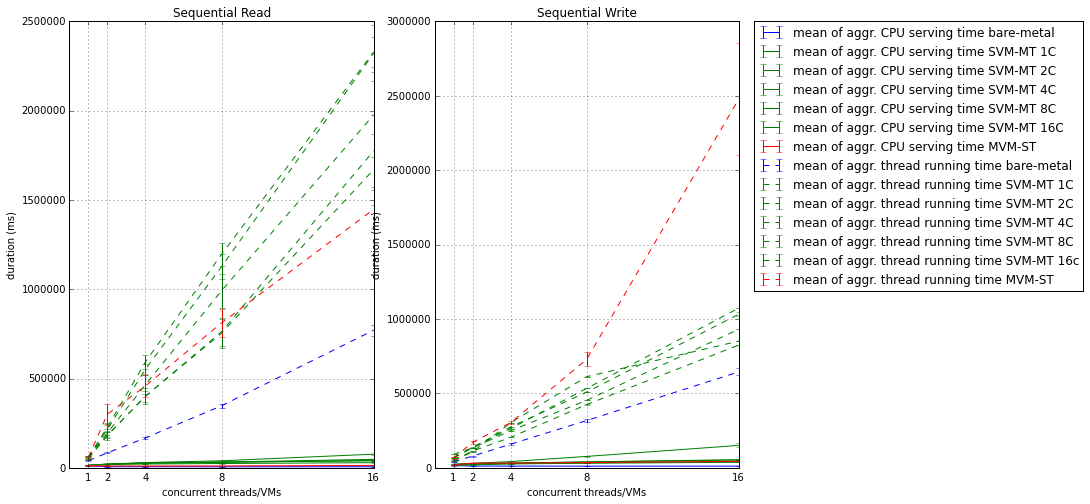

In [25]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 8  # change default size of figures

plt.subplot(121)
plt.errorbar(x_axis, tctsrbf, citctsrbf, color="blue")
plt.errorbar(x_axis, tctsrsvm1c, citctsrsvm1c, color="green")
plt.errorbar(x_axis, tctsrsvm2c, citctsrsvm2c, color="green")
plt.errorbar(x_axis, tctsrsvm4c, citctsrsvm4c, color="green")
plt.errorbar(x_axis, tctsrsvm8c, citctsrsvm8c, color="green")
plt.errorbar(x_axis, tctsrsvm16c, citctsrsvm16c, color="green")
plt.errorbar(x_axis, tctsrmvm, citctsrmvm, color="red")
plt.errorbar(x_axis, trtsrbf, citrtsrbf, ls="dashed", color="blue")
plt.errorbar(x_axis, trtsrsvm1c, citrtsrsvm1c, ls="dashed", color="green")
plt.errorbar(x_axis, trtsrsvm2c, citrtsrsvm2c, ls="dashed", color="green")
plt.errorbar(x_axis, trtsrsvm4c, citrtsrsvm4c, ls="dashed", color="green")
plt.errorbar(x_axis, trtsrsvm8c, citrtsrsvm8c, ls="dashed", color="green")
plt.errorbar(x_axis, trtsrsvm16c, citrtsrsvm16c, ls="dashed", color="green")
plt.errorbar(x_axis, trtsrmvm, citrtsrmvm, ls="dashed", color="red")
#plt.axis([0.9, 16.1, 0, 110000])
plt.grid(True)
plt.title('Sequential Read')
plt.xlabel('concurrent threads/VMs')
plt.ylabel('duration (ms)')
plt.xticks(x_axis)

plt.subplot(122)
plt.errorbar(x_axis, tctswbf, citctswbf, color="blue", label = 'mean of aggr. CPU serving time bare-metal')
plt.errorbar(x_axis, tctswsvm1c, citctswsvm1c, color="green", label = 'mean of aggr. CPU serving time SVM-MT 1C')
plt.errorbar(x_axis, tctswsvm2c, citctswsvm2c, color="green", label = 'mean of aggr. CPU serving time SVM-MT 2C')
plt.errorbar(x_axis, tctswsvm4c, citctswsvm4c, color="green", label = 'mean of aggr. CPU serving time SVM-MT 4C')
plt.errorbar(x_axis, tctswsvm8c, citctswsvm8c, color="green", label = 'mean of aggr. CPU serving time SVM-MT 8C')
plt.errorbar(x_axis, tctswsvm16c, citctswsvm16c, color="green", label = 'mean of aggr. CPU serving time SVM-MT 16C')
plt.errorbar(x_axis, tctswmvm, citctswmvm, color="red", label = 'mean of aggr. CPU serving time MVM-ST')
plt.errorbar(x_axis, trtswbf, citrtswbf, ls="dashed", color="blue", label = 'mean of aggr. thread running time bare-metal')
plt.errorbar(x_axis, trtswsvm1c, citrtswsvm1c, ls="dashed", color="green", label = 'mean of aggr. thread running time SVM-MT 1C')
plt.errorbar(x_axis, trtswsvm2c, citrtswsvm2c, ls="dashed", color="green", label = 'mean of aggr. thread running time SVM-MT 2C')
plt.errorbar(x_axis, trtswsvm4c, citrtswsvm4c, ls="dashed", color="green", label = 'mean of aggr. thread running time SVM-MT 4C')
plt.errorbar(x_axis, trtswsvm8c, citrtswsvm8c, ls="dashed", color="green", label = 'mean of aggr. thread running time SVM-MT 8C')
plt.errorbar(x_axis, trtswsvm16c, citrtswsvm16c, ls="dashed", color="green", label = 'mean of aggr. thread running time SVM-MT 16c')
plt.errorbar(x_axis, trtswmvm, citrtswmvm, ls="dashed", color="red", label = 'mean of aggr. thread running time MVM-ST')
#plt.axis([0.9, 16.1, 0, 110000])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
plt.xlabel('concurrent threads/VMs')
plt.ylabel('duration (ms)')
plt.xticks(x_axis)
#plt.savefig('CPUutilisation16procs.pdf')

We notice the waiting time for for bare-metal is greater than the virtualized one while the serving time is slower. This explain part of the reason why the throughput of baremetal is not as good as the virtualised one. But why it spends a lot of time for waiting is till a big question.

In [26]:
# for throughput per thread/VM
nml_tctsrbf = [x/y for x,y in zip(tctsrbf,tctsrbf)]
nml_tctswbf = [x/y for x,y in zip(tctswbf,tctswbf)]

nml_tctsrsvm1c = [x/y for x,y in zip(tctsrsvm1c,tctsrbf)]
nml_tctswsvm1c = [x/y for x,y in zip(tctswsvm1c,tctswbf)]
nml_tctsrsvm2c = [x/y for x,y in zip(tctsrsvm2c,tctsrbf)]
nml_tctswsvm2c = [x/y for x,y in zip(tctswsvm2c,tctswbf)]
nml_tctsrsvm4c = [x/y for x,y in zip(tctsrsvm4c,tctsrbf)]
nml_tctswsvm4c = [x/y for x,y in zip(tctswsvm4c,tctswbf)]
nml_tctsrsvm8c = [x/y for x,y in zip(tctsrsvm8c,tctsrbf)]
nml_tctswsvm8c = [x/y for x,y in zip(tctswsvm8c,tctswbf)]
nml_tctsrsvm16c = [x/y for x,y in zip(tctsrsvm16c,tctsrbf)]
nml_tctswsvm16c = [x/y for x,y in zip(tctswsvm16c,tctswbf)]

nml_tctsrmvm = [x/y for x,y in zip(tctsrmvm,tctsrbf)]
nml_tctswmvm = [x/y for x,y in zip(tctswmvm,tctswbf)]


# for throughput per thread/VM
nml_trtsrbf = [x/y for x,y in zip(trtsrbf,trtsrbf)]
nml_trtswbf = [x/y for x,y in zip(trtswbf,trtswbf)]

nml_trtsrsvm1c = [x/y for x,y in zip(trtsrsvm1c,trtsrbf)]
nml_trtswsvm1c = [x/y for x,y in zip(trtswsvm1c,trtswbf)]
nml_trtsrsvm2c = [x/y for x,y in zip(trtsrsvm2c,trtsrbf)]
nml_trtswsvm2c = [x/y for x,y in zip(trtswsvm2c,trtswbf)]
nml_trtsrsvm4c = [x/y for x,y in zip(trtsrsvm4c,trtsrbf)]
nml_trtswsvm4c = [x/y for x,y in zip(trtswsvm4c,trtswbf)]
nml_trtsrsvm8c = [x/y for x,y in zip(trtsrsvm8c,trtsrbf)]
nml_trtswsvm8c = [x/y for x,y in zip(trtswsvm8c,trtswbf)]
nml_trtsrsvm16c = [x/y for x,y in zip(trtsrsvm16c,trtsrbf)]
nml_trtswsvm16c = [x/y for x,y in zip(trtswsvm16c,trtswbf)]

nml_trtsrmvm = [x/y for x,y in zip(trtsrmvm,trtsrbf)]
nml_trtswmvm = [x/y for x,y in zip(trtswmvm,trtswbf)]


([<matplotlib.axis.XTick at 0x7f71a0747610>,
 <a list of 5 Text xticklabel objects>)

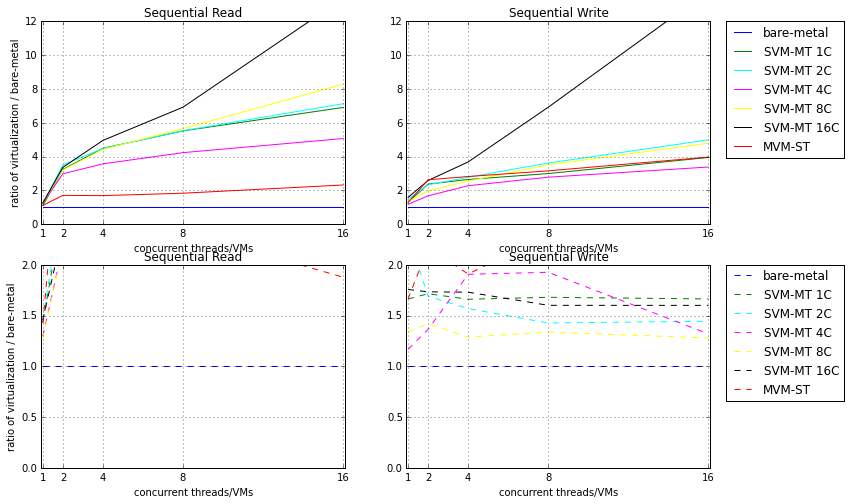

In [27]:
pylab.rcParams['figure.figsize'] = 12, 8  # change default size of figures

plt.subplot(221)
plt.plot(x_axis, nml_tctsrbf, color="blue")
plt.plot(x_axis, nml_tctsrsvm1c, color="green")
plt.plot(x_axis, nml_tctsrsvm2c, color="cyan")
plt.plot(x_axis, nml_tctsrsvm4c, color="magenta")
plt.plot(x_axis, nml_tctsrsvm8c, color="yellow")
plt.plot(x_axis, nml_tctsrsvm16c, color="black")
plt.plot(x_axis, nml_tctsrmvm, color="red")
plt.axis([0.9, 16.1, 0, 12])
plt.grid(True)
plt.title('Sequential Read')
plt.xlabel('concurrent threads/VMs')
plt.ylabel('ratio of virtualization / bare-metal')
plt.xticks(x_axis)

plt.subplot(222)
plt.plot(x_axis, nml_tctswbf, color="blue", label = 'bare-metal')
plt.plot(x_axis, nml_tctswsvm1c, color="green", label = 'SVM-MT 1C')
plt.plot(x_axis, nml_tctswsvm2c, color="cyan", label = 'SVM-MT 2C')
plt.plot(x_axis, nml_tctswsvm4c, color="magenta", label = 'SVM-MT 4C')
plt.plot(x_axis, nml_tctswsvm8c, color="yellow", label = 'SVM-MT 8C')
plt.plot(x_axis, nml_tctswsvm16c, color="black", label = 'SVM-MT 16C')
plt.plot(x_axis, nml_tctswmvm, color="red", label = 'MVM-ST')
plt.axis([0.9, 16.1, 0, 12])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('concurrent threads/VMs')
#plt.ylabel('ratio of virtualization / bare-metal')
plt.xticks(x_axis)

plt.subplot(223)
plt.plot(x_axis, nml_trtsrbf, ls="dashed", color="blue")
plt.plot(x_axis, nml_trtsrsvm1c, ls="dashed", color="green")
plt.plot(x_axis, nml_trtsrsvm2c, ls="dashed", color="cyan")
plt.plot(x_axis, nml_trtsrsvm4c, ls="dashed", color="magenta")
plt.plot(x_axis, nml_trtsrsvm8c, ls="dashed", color="yellow")
plt.plot(x_axis, nml_trtsrsvm16c, ls="dashed", color="black")
plt.plot(x_axis, nml_trtsrmvm, ls="dashed", color="red")
plt.axis([0.9, 16.1, 0, 2])
plt.grid(True)
plt.title('Sequential Read')
plt.xlabel('concurrent threads/VMs')
plt.ylabel('ratio of virtualization / bare-metal')
plt.xticks(x_axis)

plt.subplot(224)
plt.plot(x_axis, nml_trtswbf, ls="dashed", color="blue", label = 'bare-metal')
plt.plot(x_axis, nml_trtswsvm1c, ls="dashed", color="green", label = 'SVM-MT 1C')
plt.plot(x_axis, nml_trtswsvm2c, ls="dashed", color="cyan", label = 'SVM-MT 2C')
plt.plot(x_axis, nml_trtswsvm4c, ls="dashed", color="magenta", label = 'SVM-MT 4C')
plt.plot(x_axis, nml_trtswsvm8c, ls="dashed", color="yellow", label = 'SVM-MT 8C')
plt.plot(x_axis, nml_trtswsvm16c, ls="dashed", color="black", label = 'SVM-MT 16C')
plt.plot(x_axis, nml_trtswmvm, ls="dashed", color="red", label = 'MVM-ST')
plt.axis([0.9, 16.1, 0, 2])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('concurrent threads/VMs')
#plt.ylabel('ratio of virtualization / bare-metal')
plt.xticks(x_axis)

#plt.savefig('nml_CPUutilisation16procs.pdf')

## Context Switching

In [28]:
dtresult = pd.read_csv('data/cpucs16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
dtdata = dtresult[range(1,17)]
dtindex = dtresult[0]
dtdata.index = dtindex.str.replace('T[0-2][0-9]', '',case=False)

# Calculate aggregated context switching on each host of each test, then taking the average
aggcsin1test = dtdata.T.sum() # Aggregate throughput on each host in one test
avgaggcsintestgrouped = aggcsin1test.groupby(level=0)
avgaggcsin5tests = avgaggcsintestgrouped.mean() # Then calculate the average of the total CS through 5 tests
ciaggcsin5tests = avgaggcsintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%

# Putting average aggregate throughput to vector before plotting
aggcssrbf = avgaggcsin5tests.filter(regex="^SRBF32CTH").tolist()
aggcsswbf = avgaggcsin5tests.filter(regex="^SWBF32CTH").tolist()
aggcssrsvm1c = avgaggcsin5tests.filter(regex="^SR01VM01CTH").tolist()
aggcsswsvm1c = avgaggcsin5tests.filter(regex="^SW01VM01CTH").tolist()
aggcssrsvm2c = avgaggcsin5tests.filter(regex="^SR01VM02CTH").tolist()
aggcsswsvm2c = avgaggcsin5tests.filter(regex="^SW01VM02CTH").tolist()
aggcssrsvm4c = avgaggcsin5tests.filter(regex="^SR01VM04CTH").tolist()
aggcsswsvm4c = avgaggcsin5tests.filter(regex="^SW01VM04CTH").tolist()
aggcssrsvm8c = avgaggcsin5tests.filter(regex="^SR01VM08CTH").tolist()
aggcsswsvm8c = avgaggcsin5tests.filter(regex="^SW01VM08CTH").tolist()
aggcssrsvm16c = avgaggcsin5tests.filter(regex="^SR01VM16CTH").tolist()
aggcsswsvm16c = avgaggcsin5tests.filter(regex="^SW01VM16CTH").tolist()
aggcssrmvm = avgaggcsin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
aggcsswmvm = avgaggcsin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

# Confidence Interval
ciaggcssrbf = ciaggcsin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggcsswbf = ciaggcsin5tests.filter(regex="^SWBF32CTH").tolist()
ciaggcssrsvm1c = ciaggcsin5tests.filter(regex="^SR01VM01CTH").tolist()
ciaggcsswsvm1c = ciaggcsin5tests.filter(regex="^SW01VM01CTH").tolist()
ciaggcssrsvm2c = ciaggcsin5tests.filter(regex="^SR01VM02CTH").tolist()
ciaggcsswsvm2c = ciaggcsin5tests.filter(regex="^SW01VM02CTH").tolist()
ciaggcssrsvm4c = ciaggcsin5tests.filter(regex="^SR01VM04CTH").tolist()
ciaggcsswsvm4c = ciaggcsin5tests.filter(regex="^SW01VM04CTH").tolist()
ciaggcssrsvm8c = ciaggcsin5tests.filter(regex="^SR01VM08CTH").tolist()
ciaggcsswsvm8c = ciaggcsin5tests.filter(regex="^SW01VM08CTH").tolist()
ciaggcssrsvm16c = ciaggcsin5tests.filter(regex="^SR01VM16CTH").tolist()
ciaggcsswsvm16c = ciaggcsin5tests.filter(regex="^SW01VM16CTH").tolist()
ciaggcssrmvm = ciaggcsin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
ciaggcsswmvm = ciaggcsin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

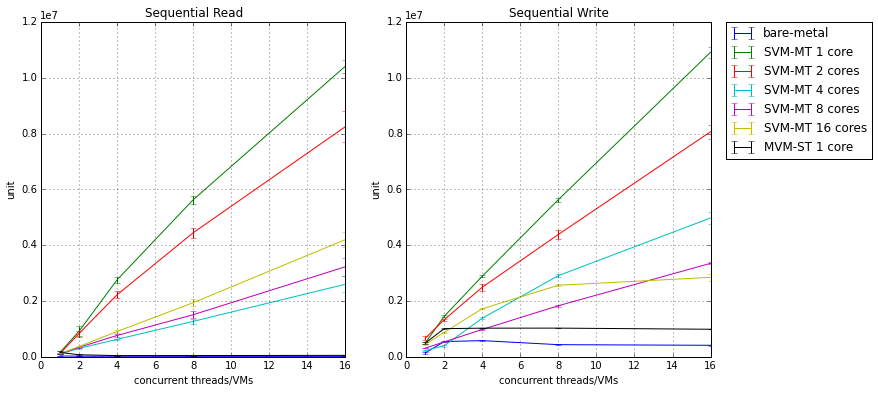

In [29]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 6  # change default size of figures

plt.subplot(121)
plt.errorbar(x_axis, aggcssrbf, ciaggcssrbf)
plt.errorbar(x_axis, aggcssrsvm1c, ciaggcssrsvm1c)
plt.errorbar(x_axis, aggcssrsvm2c, ciaggcssrsvm2c)
plt.errorbar(x_axis, aggcssrsvm4c, ciaggcssrsvm4c)
plt.errorbar(x_axis, aggcssrsvm8c, ciaggcssrsvm8c)
plt.errorbar(x_axis, aggcssrsvm16c, ciaggcssrsvm16c)
plt.errorbar(x_axis, aggcssrmvm, ciaggcssrmvm)
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('unit')

plt.subplot(122)
plt.errorbar(x_axis, aggcsswbf, ciaggcsswbf, label = 'bare-metal')
plt.errorbar(x_axis, aggcsswsvm1c, ciaggcsswsvm1c, label = 'SVM-MT 1 core')
plt.errorbar(x_axis, aggcsswsvm2c, ciaggcsswsvm2c, label = 'SVM-MT 2 cores')
plt.errorbar(x_axis, aggcsswsvm4c, ciaggcsswsvm4c, label = 'SVM-MT 4 cores')
plt.errorbar(x_axis, aggcsswsvm8c, ciaggcsswsvm8c, label = 'SVM-MT 8 cores')
plt.errorbar(x_axis, aggcsswsvm16c, ciaggcsswsvm16c, label = 'SVM-MT 16 cores')
plt.errorbar(x_axis, aggcsswmvm, ciaggcsswmvm, label = 'MVM-ST 1 core')
#plt.axis([0.9, 16.1, 0, 110])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('unit')

#plt.savefig('throughput16procs.pdf')

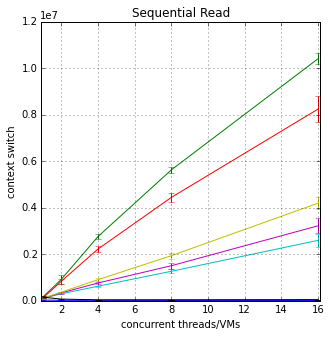

In [30]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 5, 5  # change default size of figures

plt.errorbar(x_axis, aggcssrbf, ciaggcssrbf)
plt.errorbar(x_axis, aggcssrsvm1c, ciaggcssrsvm1c)
plt.errorbar(x_axis, aggcssrsvm2c, ciaggcssrsvm2c)
plt.errorbar(x_axis, aggcssrsvm4c, ciaggcssrsvm4c)
plt.errorbar(x_axis, aggcssrsvm8c, ciaggcssrsvm8c)
plt.errorbar(x_axis, aggcssrsvm16c, ciaggcssrsvm16c)
plt.errorbar(x_axis, aggcssrmvm, ciaggcssrmvm)
plt.axis([0.9, 16.1, 0, 12000000])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('context switch')
plt.savefig('contextswitching_cfq_read.pdf')

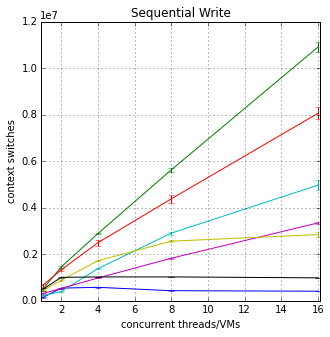

In [31]:
x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 5, 5  # change default size of figures
plt.errorbar(x_axis, aggcsswbf, ciaggcsswbf, label = 'bare-metal')
plt.errorbar(x_axis, aggcsswsvm1c, ciaggcsswsvm1c, label = 'SVM-MT 1 core')
plt.errorbar(x_axis, aggcsswsvm2c, ciaggcsswsvm2c, label = 'SVM-MT 2 cores')
plt.errorbar(x_axis, aggcsswsvm4c, ciaggcsswsvm4c, label = 'SVM-MT 4 cores')
plt.errorbar(x_axis, aggcsswsvm8c, ciaggcsswsvm8c, label = 'SVM-MT 8 cores')
plt.errorbar(x_axis, aggcsswsvm16c, ciaggcsswsvm16c, label = 'SVM-MT 16 cores')
plt.errorbar(x_axis, aggcsswmvm, ciaggcsswmvm, label = 'MVM-ST 1 core')
plt.axis([0.9, 16.1, 0, 12000000])
plt.grid(True)
plt.title('Sequential Write')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('context switches')

plt.savefig('contextswitching_cfq_write.pdf')

## IOPS

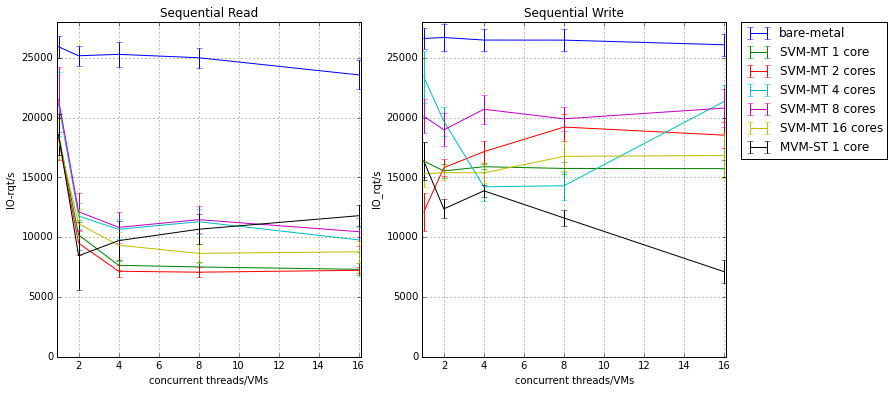

In [32]:
dtresult = pd.read_csv('data/iops16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
dtdata = dtresult[range(1,17)]
dtindex = dtresult[0]
dtdata.index = dtindex.str.replace('T[0-2][0-9]', '',case=False)

# Calculate aggregated context switching on each host of each test, then taking the average
aggiopsin1test = dtdata.T.sum() # Aggregate throughput on each host in one test
avgaggiopsintestgrouped = aggiopsin1test.groupby(level=0)
avgaggiopsin5tests = avgaggiopsintestgrouped.mean() # Then calculate the average of the total CS through 5 tests
ciaggiopsin5tests = avgaggiopsintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%

# Putting average aggregate throughput to vector before plotting
aggiopssrbf = avgaggiopsin5tests.filter(regex="^SRBF32CTH").tolist()
aggiopsswbf = avgaggiopsin5tests.filter(regex="^SWBF32CTH").tolist()
aggiopssrsvm1c = avgaggiopsin5tests.filter(regex="^SR01VM01CTH").tolist()
aggiopsswsvm1c = avgaggiopsin5tests.filter(regex="^SW01VM01CTH").tolist()
aggiopssrsvm2c = avgaggiopsin5tests.filter(regex="^SR01VM02CTH").tolist()
aggiopsswsvm2c = avgaggiopsin5tests.filter(regex="^SW01VM02CTH").tolist()
aggiopssrsvm4c = avgaggiopsin5tests.filter(regex="^SR01VM04CTH").tolist()
aggiopsswsvm4c = avgaggiopsin5tests.filter(regex="^SW01VM04CTH").tolist()
aggiopssrsvm8c = avgaggiopsin5tests.filter(regex="^SR01VM08CTH").tolist()
aggiopsswsvm8c = avgaggiopsin5tests.filter(regex="^SW01VM08CTH").tolist()
aggiopssrsvm16c = avgaggiopsin5tests.filter(regex="^SR01VM16CTH").tolist()
aggiopsswsvm16c = avgaggiopsin5tests.filter(regex="^SW01VM16CTH").tolist()
aggiopssrmvm = avgaggiopsin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
aggiopsswmvm = avgaggiopsin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

# Confidence Interval
ciaggiopssrbf = ciaggiopsin5tests.filter(regex="^SRBF32CTH").tolist()
ciaggiopsswbf = ciaggiopsin5tests.filter(regex="^SWBF32CTH").tolist()
ciaggiopssrsvm1c = ciaggiopsin5tests.filter(regex="^SR01VM01CTH").tolist()
ciaggiopsswsvm1c = ciaggiopsin5tests.filter(regex="^SW01VM01CTH").tolist()
ciaggiopssrsvm2c = ciaggiopsin5tests.filter(regex="^SR01VM02CTH").tolist()
ciaggiopsswsvm2c = ciaggiopsin5tests.filter(regex="^SW01VM02CTH").tolist()
ciaggiopssrsvm4c = ciaggiopsin5tests.filter(regex="^SR01VM04CTH").tolist()
ciaggiopsswsvm4c = ciaggiopsin5tests.filter(regex="^SW01VM04CTH").tolist()
ciaggiopssrsvm8c = ciaggiopsin5tests.filter(regex="^SR01VM08CTH").tolist()
ciaggiopsswsvm8c = ciaggiopsin5tests.filter(regex="^SW01VM08CTH").tolist()
ciaggiopssrsvm16c = ciaggiopsin5tests.filter(regex="^SR01VM16CTH").tolist()
ciaggiopsswsvm16c = ciaggiopsin5tests.filter(regex="^SW01VM16CTH").tolist()
ciaggiopssrmvm = ciaggiopsin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
ciaggiopsswmvm = ciaggiopsin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 6  # change default size of figures

plt.subplot(121)
plt.errorbar(x_axis, aggiopssrbf, ciaggiopssrbf)
plt.errorbar(x_axis, aggiopssrsvm1c, ciaggiopssrsvm1c)
plt.errorbar(x_axis, aggiopssrsvm2c, ciaggiopssrsvm2c)
plt.errorbar(x_axis, aggiopssrsvm4c, ciaggiopssrsvm4c)
plt.errorbar(x_axis, aggiopssrsvm8c, ciaggiopssrsvm8c)
plt.errorbar(x_axis, aggiopssrsvm16c, ciaggiopssrsvm16c)
plt.errorbar(x_axis, aggiopssrmvm, ciaggiopssrmvm)
plt.axis([0.9, 16.1, 0, 28000])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('IO-rqt/s')

plt.subplot(122)
plt.errorbar(x_axis, aggiopsswbf, ciaggiopsswbf, label = 'bare-metal')
plt.errorbar(x_axis, aggiopsswsvm1c, ciaggiopsswsvm1c, label = 'SVM-MT 1 core')
plt.errorbar(x_axis, aggiopsswsvm2c, ciaggiopsswsvm2c, label = 'SVM-MT 2 cores')
plt.errorbar(x_axis, aggiopsswsvm4c, ciaggiopsswsvm4c, label = 'SVM-MT 4 cores')
plt.errorbar(x_axis, aggiopsswsvm8c, ciaggiopsswsvm8c, label = 'SVM-MT 8 cores')
plt.errorbar(x_axis, aggiopsswsvm16c, ciaggiopsswsvm16c, label = 'SVM-MT 16 cores')
plt.errorbar(x_axis, aggiopsswmvm, ciaggiopsswmvm, label = 'MVM-ST 1 core')
plt.axis([0.9, 16.1, 0, 28000])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('IO_rqt/s')

#plt.savefig('throughput16procs.pdf')

## Latencies

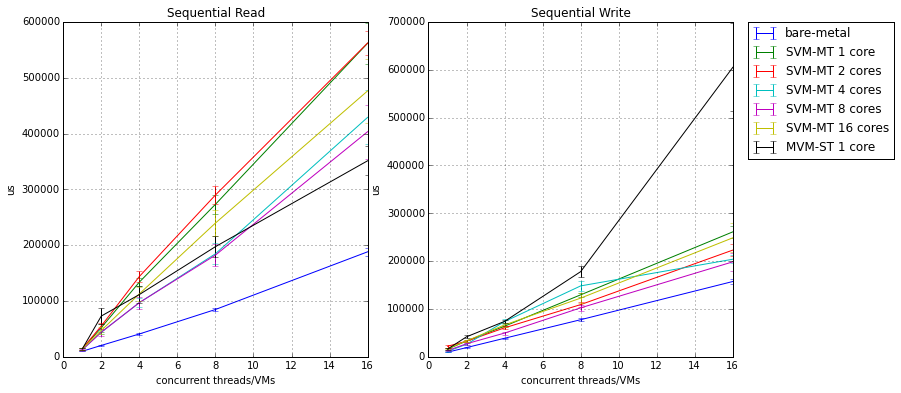

In [33]:
dtresult = pd.read_csv('data/lat16p4gbf12cache_cfq.csv', delimiter=' ', header=None)
dtdata = dtresult[range(1,17)]
dtindex = dtresult[0]
dtdata.index = dtindex.str.replace('T[0-2][0-9]', '',case=False)

# mean of all member in diferent group = mean of group mean when all groups have same number of member
# Calculate aggregated context switching on each host of each test, then taking the average
latin1test = dtdata.T.mean()
avglatintestgrouped = latin1test.groupby(level=0)
avglatin5tests = avglatintestgrouped.aggregate(np.mean) # Then calculate the average of the total CS through 5 tests
cilatin5tests = avglatintestgrouped.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # Confident interval of 95%

# Putting average aggregate throughput to vector before plotting
latsrbf = avglatin5tests.filter(regex="^SRBF32CTH").tolist()
latswbf = avglatin5tests.filter(regex="^SWBF32CTH").tolist()
latsrsvm1c = avglatin5tests.filter(regex="^SR01VM01CTH").tolist()
latswsvm1c = avglatin5tests.filter(regex="^SW01VM01CTH").tolist()
latsrsvm2c = avglatin5tests.filter(regex="^SR01VM02CTH").tolist()
latswsvm2c = avglatin5tests.filter(regex="^SW01VM02CTH").tolist()
latsrsvm4c = avglatin5tests.filter(regex="^SR01VM04CTH").tolist()
latswsvm4c = avglatin5tests.filter(regex="^SW01VM04CTH").tolist()
latsrsvm8c = avglatin5tests.filter(regex="^SR01VM08CTH").tolist()
latswsvm8c = avglatin5tests.filter(regex="^SW01VM08CTH").tolist()
latsrsvm16c = avglatin5tests.filter(regex="^SR01VM16CTH").tolist()
latswsvm16c = avglatin5tests.filter(regex="^SW01VM16CTH").tolist()
latsrmvm = avglatin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
latswmvm = avglatin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

# Confidence Interval
cilatsrbf = cilatin5tests.filter(regex="^SRBF32CTH").tolist()
cilatswbf = cilatin5tests.filter(regex="^SWBF32CTH").tolist()
cilatsrsvm1c = cilatin5tests.filter(regex="^SR01VM01CTH").tolist()
cilatswsvm1c = cilatin5tests.filter(regex="^SW01VM01CTH").tolist()
cilatsrsvm2c = cilatin5tests.filter(regex="^SR01VM02CTH").tolist()
cilatswsvm2c = cilatin5tests.filter(regex="^SW01VM02CTH").tolist()
cilatsrsvm4c = cilatin5tests.filter(regex="^SR01VM04CTH").tolist()
cilatswsvm4c = cilatin5tests.filter(regex="^SW01VM04CTH").tolist()
cilatsrsvm8c = cilatin5tests.filter(regex="^SR01VM08CTH").tolist()
cilatswsvm8c = cilatin5tests.filter(regex="^SW01VM08CTH").tolist()
cilatsrsvm16c = cilatin5tests.filter(regex="^SR01VM16CTH").tolist()
cilatswsvm16c = cilatin5tests.filter(regex="^SW01VM16CTH").tolist()
cilatsrmvm = cilatin5tests.filter(regex="^SR[0-9]+VM01CTH01").tolist()
cilatswmvm = cilatin5tests.filter(regex="^SW[0-9]+VM01CTH01").tolist()

x_axis = [1,2,4,8,16]
pylab.rcParams['figure.figsize'] = 12, 6  # change default size of figures

plt.subplot(121)
plt.errorbar(x_axis, latsrbf, cilatsrbf)
plt.errorbar(x_axis, latsrsvm1c, cilatsrsvm1c)
plt.errorbar(x_axis, latsrsvm2c, cilatsrsvm2c)
plt.errorbar(x_axis, latsrsvm4c, cilatsrsvm4c)
plt.errorbar(x_axis, latsrsvm8c, cilatsrsvm8c)
plt.errorbar(x_axis, latsrsvm16c, cilatsrsvm16c)
plt.errorbar(x_axis, latsrmvm, cilatsrmvm)
#plt.axis([0.9, 16.1, 0, 28000])
plt.grid(True)
plt.title('Sequential Read')
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('us')

plt.subplot(122)
plt.errorbar(x_axis, latswbf, cilatswbf, label = 'bare-metal')
plt.errorbar(x_axis, latswsvm1c, cilatswsvm1c, label = 'SVM-MT 1 core')
plt.errorbar(x_axis, latswsvm2c, cilatswsvm2c, label = 'SVM-MT 2 cores')
plt.errorbar(x_axis, latswsvm4c, cilatswsvm4c, label = 'SVM-MT 4 cores')
plt.errorbar(x_axis, latswsvm8c, cilatswsvm8c, label = 'SVM-MT 8 cores')
plt.errorbar(x_axis, latswsvm16c, cilatswsvm16c, label = 'SVM-MT 16 cores')
plt.errorbar(x_axis, latswmvm, cilatswmvm, label = 'MVM-ST 1 core')
#plt.axis([0.9, 16.1, 0, 28000])
plt.grid(True)
plt.title('Sequential Write')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel('concurrent threads/VMs')
pylab.ylabel('us')

#plt.savefig('throughput16procs.pdf')

## Disk Utilization

Disk was used by 100% in all cases.